#Libraries

In [ ]:
# 1. Cài đặt thư viện
!pip install easyocr --quiet
!pip install -q underthesea pyvi seacrowd huggingface_hub torchvision tqdm transformers torch
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
# 2. Imports
import os
import uuid
import math
import re
import json
import warnings
import random
import pathlib
import unicodedata
from collections import Counter, defaultdict
from tqdm import tqdm
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models

from sklearn.metrics import accuracy_score, f1_score

import easyocr
import seacrowd as sc
from datasets import Dataset, load_dataset
from underthesea import text_normalize, word_tokenize
from pyvi import ViTokenizer
from transformers import AutoTokenizer

In [ ]:
# 3. Thiết lập
warnings.filterwarnings("ignore")
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())   # chỉ để DETECT

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
torch.manual_seed(42);  random.seed(42);  np.random.seed(42)

#Bài 1: Tìm hiểu chuyên sâu về các cơ chế Attention trong các mô hình ngôn ngữ lớn (LLMs)

##Trình bày lý thuyết chuyên sâu:

###Self-Attention

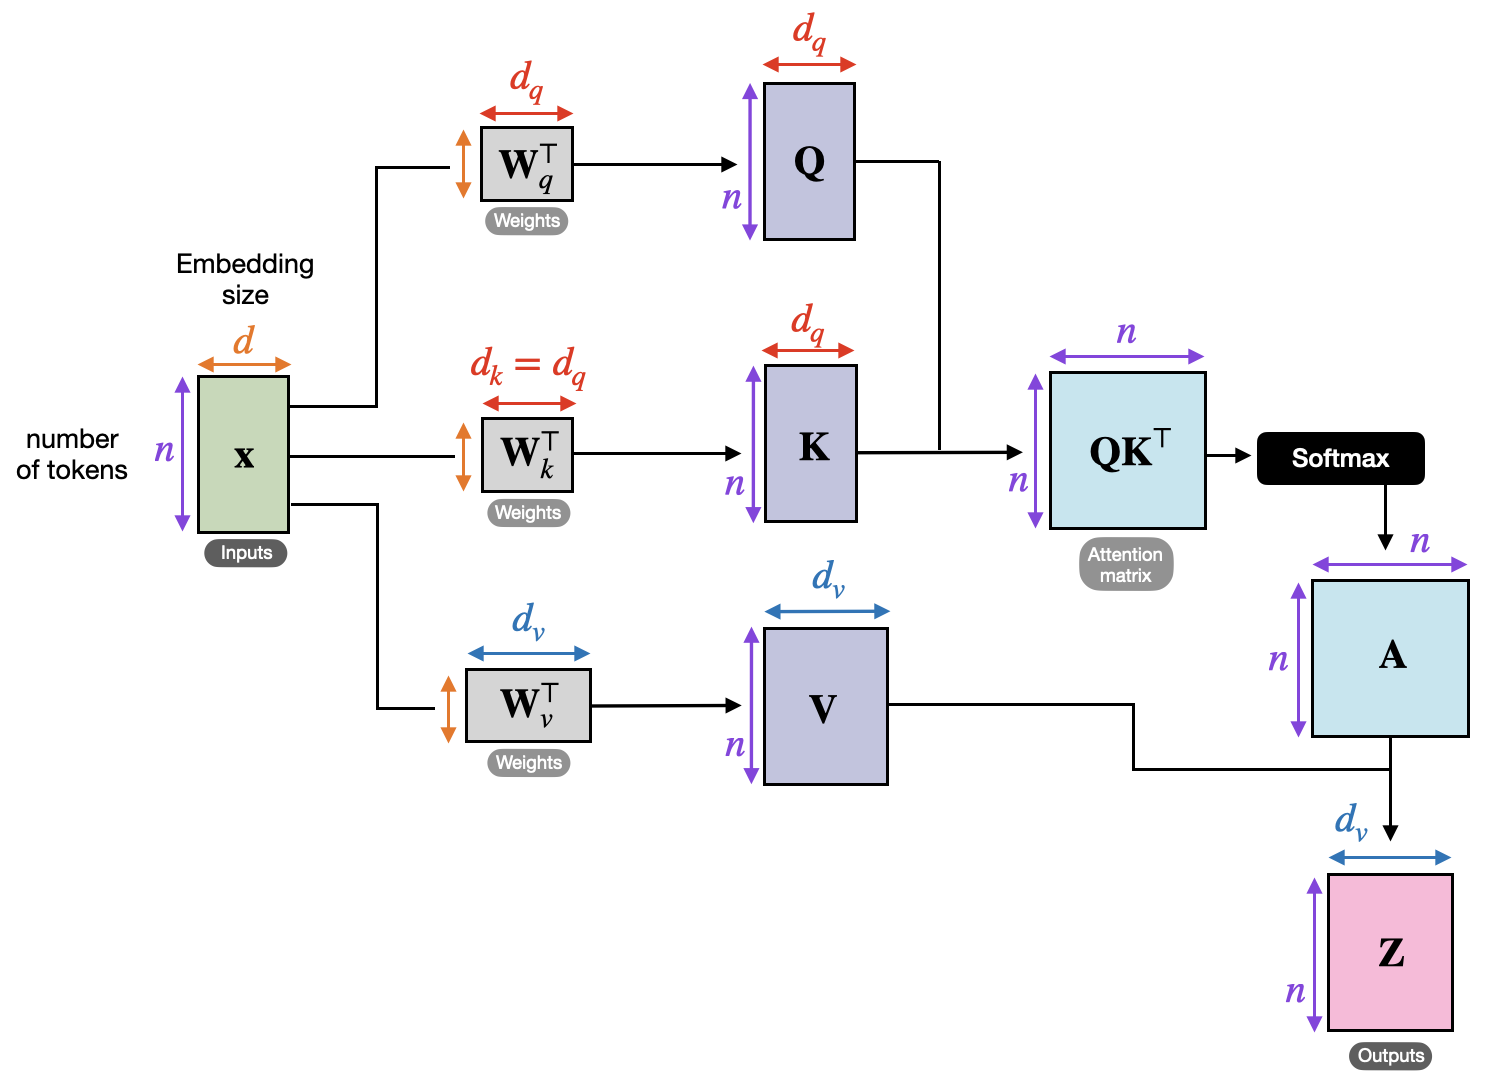

**Giải thích cơ chế hoạt động, ý tưởng chính**

* Ý tưởng chính: cho phép mỗi phần tử trong chuỗi (một từ, một token) tự “chú ý” đến tất cả các phần tử khác, từ đó tổng hợp thông tin quan trọng bất kể khoảng cách vị trí.

* Cơ chế:

 * Chuyển đổi: mỗi embedding sinh ra ba vector: Query, Key, Value.

 * Tính điểm chú ý: $\alpha_{ij} = \frac{q_i \cdot k_j}{\sqrt{d_k}}$

 * Chuẩn hóa:
$$
a_{ij} = \mathrm{softmax}_j(\alpha_{ij})
= \frac{\exp(\alpha_{ij})}{\sum_{t=1}^n \exp(\alpha_{it})}
$$

 * Tổng hợp: output tại vị trí i
$$
z_i = \sum_{j=1}^n a_{ij}\,v_j
$$

* Multi-Head: làm nhiều phép tính song song với các bộ Q/K/V khác nhau để mô hình học “chú ý” ở nhiều khía cạnh, rồi ghép kết quả lại.

---

**Độ phức tạp tính toán**

Giả sử:
- Chuỗi đầu vào dài $n$.  
- Kích thước embedding $d_{model}$.  
- Có $h$ head, mỗi head có kích thước $d_k = d_{model} / h$.

1. Tính Q, K, V (Projection)

- **Mục đích**: Chiếu mỗi embedding $x_i$ thành ba vector:  
  - Query: $q_i = x_i W^Q$  
  - Key:   $k_i = x_i W^K$  
  - Value: $v_i = x_i W^V$  

- **Độ phức tạp**: Nhân ma trận $X\in\mathbb{R}^{n\times d_{model}}$ với mỗi $W\in\mathbb{R}^{d_{model}\times d_k}$  
  $$
  O\bigl(n \times d_{model} \times d_k\bigr)
  $$  
  Tổng cho Q, K, V là $O(3\,n\,d_{model}\,d_k)$.

2. Tính điểm chú ý (Scaled Dot-Product)

- **Công thức**:  
  $$
  \alpha_{ij} = \frac{q_i \cdot k_j}{\sqrt{d_k}}
  $$
- **Độ phức tạp**: Phải tính cho mọi cặp $(i,j)$  
  $$
  O(n^2 \times d_k)
  $$

3. Chuẩn hóa (Softmax)

- **Công thức**:  
  $$
  a_{ij} = \frac{\exp(\alpha_{ij})}{\sum_{t=1}^n \exp(\alpha_{it})}
  $$
- **Độ phức tạp**: $O(n^2)$

4. Tổng hợp (Weighted Sum)

- **Công thức**:  
  $$
  z_i = \sum_{j=1}^n a_{ij}\,v_j
  $$
- **Độ phức tạp**: $O(n^2 \times d_k)$

5. Multi-Head Attention

- Có $h$ head, mỗi head tốn $O(n^2 d_k)$, và $h\,d_k = d_{model}$  
- **Tổng độ phức tạp**:  
  $$
  O\bigl(h \times (n^2 d_k)\bigr) \;=\; O(n^2\,d_{model})
  $$


**Tóm lại**  
- **Thời gian**: $O(n^2\,d_{model})$ cho mỗi lớp Self-Attention.  
- **Bộ nhớ**: Cần lưu ma trận điểm chú ý kích thước $n\times n$, tức $O(n^2)$.

---

**Ưu điểm và hạn chế**

* Ưu điểm của Self-Attention

 - **Nắm bắt mối quan hệ dài hạn**  
  Mỗi token có thể “chú ý” đến bất kỳ token nào khác trong chuỗi, dù ở khoảng cách lớn, giúp mô hình hiểu ngữ cảnh toàn cục.  
 - **Tính song song cao**  
  Toàn bộ ma trận Q, K, V và phép nhân dot‐product được tính đồng thời cho tất cả vị trí, tận dụng tốt GPU/TPU.  
 - **Đa khía cạnh (Multi-Head)**  
  Nhiều head chú ý học được các khía cạnh khác nhau của dữ liệu (ngữ nghĩa, cú pháp…), tăng khả năng biểu diễn.  
 - **Không phụ thuộc thứ tự tuần tự**  
  Kết hợp với positional encoding, mô hình không cần xử lý tuần tự như RNN, linh hoạt hơn cho các độ dài chuỗi khác nhau.  

* Hạn chế của Self-Attention

 - **Chi phí tính toán cao**  
  Phép dot-product trên cặp \((i,j)\) gây độ phức tạp \(O(n^2\,d_\text{model})\), khó mở rộng với chuỗi rất dài.  
 - **Tiêu tốn bộ nhớ**  
  Ma trận attention kích thước \(n\times n\) tốn \(O(n^2)\) bộ nhớ, có thể vượt hạn mức GPU cho \(n\) lớn.  
 - **Thiếu hiển thị vị trí cục bộ**  
  Dễ “mờ nhạt” thông tin cục bộ (local patterns) so với các mô hình CNN nếu không được kết hợp thêm cơ chế bổ trợ.  
 - **Khó giải thích**  
  Mặc dù cho biết được trọng số chú ý, nhưng không dễ để xác định chính xác lý do mô hình “chú ý” vào vị trí nào trong ngữ cảnh phức tạp.  

---

**So sánh với self-attention gốc trong Transformer**

| Tiêu chí                  | Self-Attention đơn giản                                                                                  | Self-Attention gốc (Transformer)                                                                                                                                     |
|---------------------------|----------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Số head**               | 1 head                                                                                                   | Multi-Head Attention (thường $h=8$ hoặc $16$ heads) – mỗi head học một “khía cạnh” khác nhau của ngữ cảnh                                                            |
| **Projection (Q, K, V)**  | Dùng 3 ma trận $W^Q, W^K, W^V$ chung cho tất cả tokens                                                   | Mỗi head có bộ ma trận riêng $W^Q_\ell, W^K_\ell, W^V_\ell$ ($\ell=1\ldots h$), rồi concat kết quả và chiếu qua $W^O$                                              |
| **Scaled Dot-Product**    | $\displaystyle \alpha_{ij} = \frac{q_i \cdot k_j}{\sqrt{d_k}}$                                             | Giống hệt (kèm scale factor $\frac{1}{\sqrt{d_k}}$ để ổn định softmax)                                                                                                |
| **Softmax & Weighted Sum**| $\displaystyle z_i = \sum_{j=1}^n a_{ij}\,v_j$                                                              | Giống hệt                                                                                                                                                             |
| **Positional Encoding**   | Không – mất thông tin thứ tự                                                                             | Có: thêm positional encoding vào embedding đầu vào để giữ thông tin vị trí                                                                                           |
| **Residual & LayerNorm**  | Không                                                                                                    | Sau Multi-Head:  
1. **Residual**: $X + \mathrm{MultiHead}(X)$  
2. **LayerNorm**  
Tương tự trước và sau Feed-Forward layer cũng có Add & Norm                                                               |
| **Feed-Forward**          | Không                                                                                                    | Mỗi block Attention được theo sau bởi FFN:  
$$
\mathrm{FFN}(x) = \mathrm{ReLU}\bigl(xW_1 + b_1\bigr)\,W_2 + b_2
$$  
kèm residual + layer norm                                                                                                           |
| **Đầu ra**                | $Z \in \mathbb{R}^{n\times d_k}$                                                                          | $Z \in \mathbb{R}^{n\times d_{\text{model}}}$ (sau concat và projection với $W^O$)                                                                                   |
| **Độ phức tạp**           | $O(n^2\,d_k)$ cho mỗi head                                                                                | $O(n^2\,d_{\text{model}})$ (vì có $h$ head và $h\,d_k = d_{\text{model}}$)                                                                                            |

**Giải thích ngắn gọn**  
- **Self-Attention đơn giản**: chỉ minh hoạ công thức cốt lõi (Q/K/V → score → softmax → weighted sum).  
- **Self-Attention gốc**: mở rộng thành block Transformer với multi-head, positional encoding, residual + layer-norm, và feed-forward để tăng khả năng biểu diễn và ổn định huấn luyện.  

---

**Ứng dụng trong các mô hình LLM (large language model) hiện đại**

Self-Attention là “xương sống” cho mọi Transformer-based LLM. Dưới đây là một số cách các mô hình hiện đại tận dụng và tối ưu cơ chế này:

1. Kiến trúc Decoder-Only (GPT, LLaMA, …)  
- **Xếp tầng nhiều lớp**: Hàng chục đến hàng trăm lớp self-attention chồng lên nhau, mỗi lớp lại có multi-head, giúp mô hình học ngữ cảnh rất sâu.  
- **Causal Masking**: Giới hạn attention chỉ về phía trái (past tokens), đảm bảo tính autoregressive khi sinh văn bản.

2. Kiến trúc Encoder-Only (BERT, RoBERTa, …)  
- **Bidirectional Attention**: Mỗi token được phép attend cả trước và sau, cho embeddings “toàn cục” rất mạnh trong các tác vụ hiểu ngôn ngữ (classification, NER, QA).

3. Encoder-Decoder (T5, BART, …)  
- **Cross-Attention**: Ở phần decoder, ngoài self-attention, còn có cơ chế attention tới đầu ra encoder, giúp dịch máy, tóm tắt văn bản chính xác hơn.

4. Mở rộng ngữ cảnh dài  
- **Sparse / Efficient Attention** (Longformer, BigBird, ETC): Chỉ attend những vị trí quan trọng hoặc theo pattern (windowed, global tokens) để giảm độ phức tạp từ \(O(n^2)\) xuống gần \(O(n\log n)\) hoặc \(O(n)\).  
- **Recurrent Memory** (Transformer-XL, Compressive Transformer): Lưu trữ hidden states cũ làm “memory” để attend qua nhiều đoạn dài hơn.

5. Kết hợp Retrieval (RAG, RETRO, Atlas)  
- Trước khi tính self-attention, truy vấn một bộ văn bản bên ngoài, sau đó cho phép attention tới những đoạn tài liệu liên quan, cải thiện độ chính xác và rong (factuality).

6. LoRA / Prefix-Tuning / Prompt Tuning  
- **Adapter-Based**: Thêm vào các low-rank matrices hoặc prefix embeddings có thể attend vào hidden states gốc, fine-tune rất tiết kiệm tài nguyên so với cập nhật toàn bộ trọng số.

7. Multi-Modal Attention  
- Ở các LLM hỗ trợ hình ảnh (GPT-4, Flamingo, …), Self-Attention kéo dài sang embedding ảnh/video, cho phép attend lẫn giữa text và các token thị giác.

8. Các cải tiến khác  
- **Rotary Positional Embedding (RoPE)**: Thay vì positional encoding cố định, dùng xoay vector key/query giúp attention hiểu thứ tự tốt hơn.  
- **FlashAttention, xFormers**: Triển khai attention cực nhanh, tối ưu GPU memory và bandwidth.

**Tóm lại**, Self-Attention trong LLM ngày nay không chỉ là phép scaled dot-product cơ bản mà còn được mở rộng theo nhiều hướng: sparse, memory, retrieval, adapter, và multi-modal, nhằm đáp ứng bối cảnh dài, tính khả chuyển, và hiệu năng huấn luyện/sinh văn bản của các mô hình quy mô hàng trăm tỷ đến nghìn tỷ tham số.  

###Multi-Query Attention (MQA)

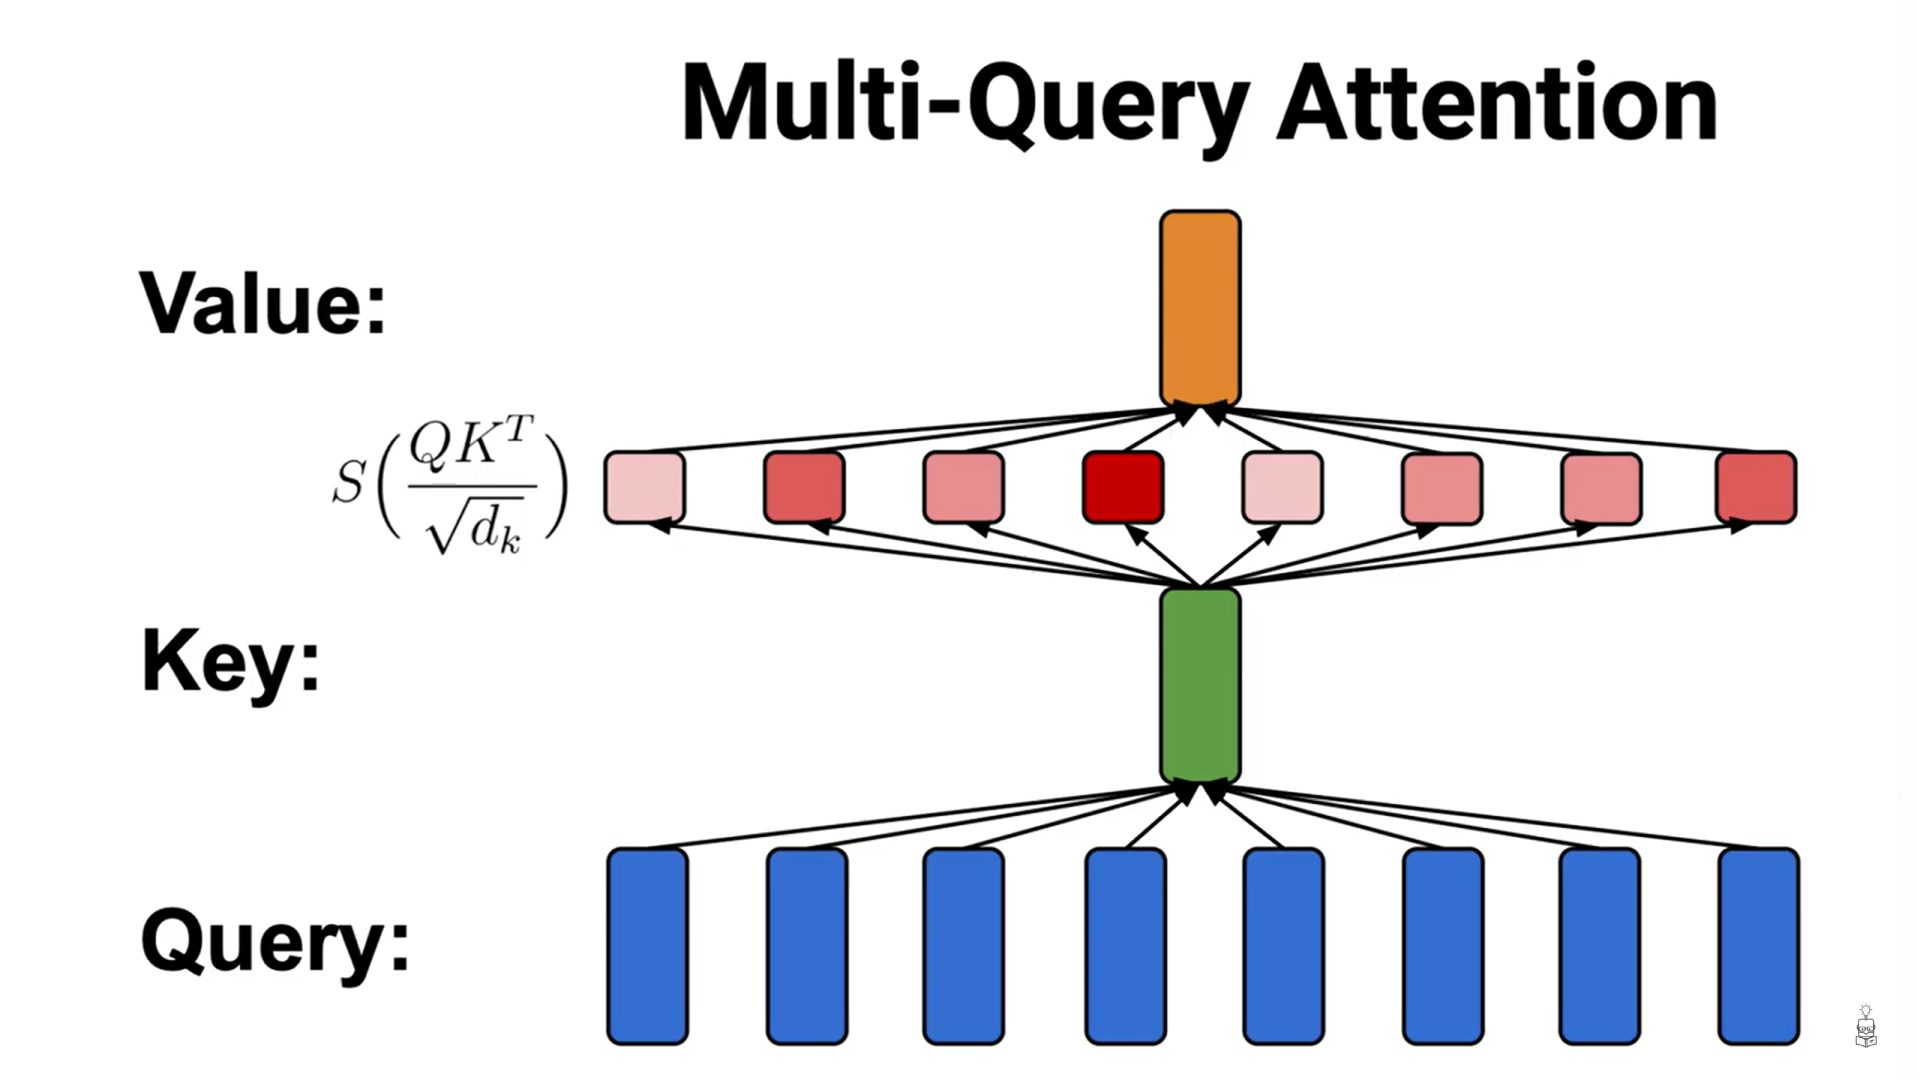

**Giải thích cơ chế hoạt động, ý tưởng chính**

**Ý tưởng chính**

Multi-Query Attention (MQA) là một biến thể của Multi-Head Attention (MHA) trong Transformer, tối ưu hóa hiệu suất và bộ nhớ, đặc biệt trong các tác vụ sinh văn bản (autoregressive generation). **Ý tưởng chính**: Chia sẻ một **Key** và **Value** duy nhất cho tất cả các head, trong khi mỗi head vẫn giữ **Query** riêng, giúp giảm chi phí tính toán và bộ nhớ khi xử lý chuỗi dài.

**Cơ chế**

MQA hoạt động tương tự Multi-Head Attention nhưng có một số thay đổi:

1. **Chuyển đổi (Projection)**:
   - Mỗi embedding đầu vào $x_i$ sinh ra:
     - **Query**: $q_i^\ell = x_i W^Q_\ell$ cho mỗi head $\ell = 1, \dots, h$.
     - **Key**: $k_i = x_i W^K$, dùng chung cho tất cả head.
     - **Value**: $v_i = x_i W^V$, dùng chung cho tất cả head.
   - Kích thước: $W^Q_\ell \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K, W^V \in \mathbb{R}^{d_{\text{model}} \times d_v}$, với $d_k = d_v = d_{\text{model}} / h$.

2. **Tính điểm chú ý (Scaled Dot-Product)**:
   - Công thức:
     $$
     \alpha_{ij}^\ell = \frac{q_i^\ell \cdot k_j}{\sqrt{d_k}}
     $$
   - Mỗi head $\ell$ tính điểm chú ý riêng, nhưng sử dụng cùng ma trận Key $K$.

3. **Chuẩn hóa (Softmax)**
Chuẩn hóa điểm chú ý trên mỗi head:
$$
a_{ij}^\ell = \mathrm{softmax}_j(\alpha_{ij}^\ell) = \frac{\exp(\alpha_{ij}^\ell)}{\sum_{t=1}^n \exp(\alpha_{it}^\ell)}
$$

4.  **Tổng hợp (Weighted Sum)**
Tính đầu ra cho mỗi head:
$$
z_i^\ell = \sum_{j=1}^n a_{ij}^\ell v_j
$$
Các đầu ra từ $h$ head được ghép (concatenate) và chiếu qua ma trận $W^O \in \mathbb{R}^{h \cdot d_v \times d_{\text{model}}}$:
$$
Z = \text{Concat}(z_i^1, \dots, z_i^h) W^O
$$

5. **Multi-Query**:
   - Khác với Multi-Head Attention, MQA chỉ sử dụng **một ma trận Key và Value** cho tất cả head, giúp giảm bộ nhớ và tăng tốc độ, đặc biệt trong các mô hình autoregressive.

---

**Độ phức tạp tính toán**

Giả sử:
- Chuỗi đầu vào dài $n$.
- Kích thước embedding $d_{\text{model}}$.
- Có $h$ head, mỗi head có kích thước $d_k = d_v = d_{\text{model}} / h$.

1. **Tính Q, K, V (Projection)**:
   - Query: $h$ ma trận $W^Q_\ell$, mỗi ma trận nhân với $X \in \mathbb{R}^{n \times d_{\text{model}}}$, tốn $O(n \cdot d_{\text{model}} \cdot d_k)$ cho mỗi head, tổng cộng $O(h \cdot n \cdot d_{\text{model}} \cdot d_k) = O(n \cdot d_{\text{model}}^2)$.
   - Key và Value: Chỉ cần một ma trận $W^K$ và $W^V$, nên tốn $O(n \cdot d_{\text{model}} \cdot d_k)$.
   - Tổng: $O(n \cdot d_{\text{model}}^2 + 2 \cdot n \cdot d_{\text{model}} \cdot d_k) \approx O(n \cdot d_{\text{model}}^2)$.

2. **Tính điểm chú ý (Scaled Dot-Product)**:
   - Mỗi head tính $q_i^\ell \cdot k_j$ cho mọi cặp $(i,j)$, tốn $O(n^2 \cdot d_k)$.
   - Tổng cho $h$ head: $O(h \cdot n^2 \cdot d_k) = O(n^2 \cdot d_{\text{model}})$.

3. **Chuẩn hóa (Softmax)**:
   - Chuẩn hóa trên $n$ điểm cho mỗi head: $O(h \cdot n^2) = O(n^2)$ (vì $h$ thường nhỏ).

4. **Tổng hợp (Weighted Sum)**:
   - Mỗi head tính $z_i^\ell$, tốn $O(n^2 \cdot d_k)$.
   - Tổng cho $h$ head: $O(h \cdot n^2 \cdot d_k) = O(n^2 \cdot d_{\text{model}})$.

5. **Projection đầu ra**:
   - Ghép và chiếu qua $W^O$: $O(n \cdot h \cdot d_k \cdot d_{\text{model}}) = O(n \cdot d_{\text{model}}^2)$.

**Tóm lại**:
- **Thời gian**: $O(n^2 \cdot d_{\text{model}})$ (tương tự Multi-Head Attention).
- **Bộ nhớ**: Ma trận Key và Value giảm từ $O(n \cdot h \cdot d_k)$ xuống $O(n \cdot d_k)$, tiết kiệm đáng kể bộ nhớ. Ma trận chú ý vẫn tốn $O(h \cdot n^2)$.

---

**Ưu điểm và hạn chế**

**Ưu điểm của Multi-Query Attention**
- **Tiết kiệm bộ nhớ**: Chỉ lưu một ma trận Key và Value thay vì $h$ ma trận, giảm bộ nhớ từ $O(n \cdot h \cdot d_k)$ xuống $O(n \cdot d_k)$.
- **Tăng tốc suy luận**: Chia sẻ Key và Value giúp tối ưu hóa tính toán trong autoregressive generation, đặc biệt khi dùng KV caching.
- **Tính song song cao**: Vẫn tận dụng GPU/TPU tốt như Multi-Head Attention.
- **Hiệu quả với chuỗi dài**: Phù hợp cho các mô hình cần xử lý ngữ cảnh dài.

**Hạn chế của Multi-Query Attention**
- **Giảm tính đa dạng của head**: Chia sẻ Key và Value làm các head ít độc lập hơn, có thể giảm khả năng học các khía cạnh khác nhau.
- **Hiệu suất huấn luyện thấp hơn**: MQA tối ưu cho suy luận hơn huấn luyện, do chia sẻ Key/Value có thể hạn chế khả năng biểu diễn.
- **Vẫn tốn bộ nhớ cho ma trận chú ý**: Ma trận chú ý $O(h \cdot n^2)$ vẫn là nút thắt cổ chai khi $n$ lớn.
- **Phụ thuộc vào thiết kế mô hình**: Hiệu quả của MQA phụ thuộc vào KV caching và các tối ưu khác.

---

**So sánh với self-attention gốc trong Transformer**

| Tiêu chí                  | Multi-Query Attention (MQA)                                    | Self-Attention gốc (Transformer)                              |
|---------------------------|---------------------------------------------------------------|-------------------------------------------------------------|
| **Số head**               | Nhiều head ($h$), chia sẻ Key và Value duy nhất               | Nhiều head ($h$), mỗi head có Query, Key, Value riêng        |
| **Projection (Q, K, V)**  | $h$ ma trận $W^Q_\ell$, 1 ma trận $W^K$, 1 ma trận $W^V$      | $h$ ma trận $W^Q_\ell, W^K_\ell, W^V_\ell$                  |
| **Scaled Dot-Product**    | $\alpha_{ij}^\ell = \frac{q_i^\ell \cdot k_j}{\sqrt{d_k}}$   | $\alpha_{ij}^\ell = \frac{q_i^\ell \cdot k_j^\ell}{\sqrt{d_k}}$ |
| **Softmax & Weighted Sum**| $z_i^\ell = \sum_{j=1}^n a_{ij}^\ell \, v_j$, dùng chung $v_j$ | $z_i^\ell = \sum_{j=1}^n a_{ij}^\ell \, v_j^\ell$           |
| **Positional Encoding**   | Thường có, tương tự Transformer                              | Có: thêm positional encoding vào embedding đầu vào          |
| **Residual & LayerNorm**  | Thường có, tương tự Transformer                              | Có: Residual + LayerNorm sau Multi-Head và Feed-Forward     |
| **Feed-Forward**          | Thường có, tương tự Transformer                              | Có: FFN sau mỗi block Attention                             |
| **Đầu ra**                | $Z \in \mathbb{R}^{n \times d_{\text{model}}}$ (sau concat và $W^O$) | $Z \in \mathbb{R}^{n \times d_{\text{model}}}$ (sau concat và $W^O$) |
| **Độ phức tạp (thời gian)** | $O(n^2 \cdot d_{\text{model}})$                              | $O(n^2 \cdot d_{\text{model}})$                             |
| **Độ phức tạp (bộ nhớ)**  | Tiết kiệm hơn: $O(n \cdot d_k)$ cho K/V, $O(h \cdot n^2)$ cho ma trận chú ý | $O(n \cdot h \cdot d_k)$ cho K/V, $O(h \cdot n^2)$ cho ma trận chú ý |

**Giải thích ngắn gọn**:
- **MQA**: Biến thể của Multi-Head Attention, chia sẻ Key và Value giữa các head để giảm bộ nhớ và tăng tốc suy luận.
- **Self-Attention gốc**: Sử dụng bộ Query, Key, Value riêng cho mỗi head, tăng tính đa dạng biểu diễn nhưng tốn bộ nhớ hơn.

---

**Ứng dụng trong các mô hình LLM (large language model) hiện đại**

Ý tưởng chính

Grouped-Query Attention (GQA) là một biến thể của Multi-Head Attention (MHA) trong Transformer, nằm giữa MHA và Multi-Query Attention (MQA). Ý tưởng chính: Chia các head thành $g$ nhóm, mỗi nhóm chia sẻ một bộ Key và Value, trong khi mỗi head trong nhóm giữ Query riêng, giúp giảm chi phí bộ nhớ so với MHA và duy trì tính đa dạng biểu diễn tốt hơn MQA.

Cơ chế

GQA hoạt động tương tự Multi-Head Attention nhưng có một số thay đổi:





Chuyển đổi (Projection):





Mỗi embedding đầu vào $x_i$ sinh ra:





Query: $q_i^\ell = x_i W^Q_\ell$ cho mỗi head $\ell = 1, \dots, h$.



Key: $k_i^m = x_i W^K_m$, dùng chung cho nhóm $m = 1, \dots, g$.



Value: $v_i^m = x_i W^V_m$, dùng chung cho nhóm $m = 1, \dots, g$.



Kích thước: $W^Q_\ell \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_m, W^V_m \in \mathbb{R}^{d_{\text{model}} \times d_v}$, với $d_k = d_v = d_{\text{model}} / h$.



Tính điểm chú ý (Scaled Dot-Product):





Công thức: $$ \alpha_{ij}^\ell = \frac{q_i^\ell \cdot k_j^m}{\sqrt{d_k}} $$



Mỗi head $\ell$ tính điểm chú ý riêng, nhưng sử dụng cùng ma trận Key $K^m$ của nhóm.



Chuẩn hóa (Softmax):





Chuẩn hóa điểm chú ý trên mỗi head: $$ a_{ij}^\ell = \mathrm{softmax}j(\alpha{ij}^\ell) = \frac{\exp(\alpha_{ij}^\ell)}{\sum_{t=1}^n \exp(\alpha_{it}^\ell)} $$



Tổng hợp (Weighted Sum):





Tính đầu ra cho mỗi head: $$ z_i^\ell = \sum_{j=1}^n a_{ij}^\ell , v_j^m $$



Các đầu ra từ $h$ head được ghép (concatenate) và chiếu qua ma trận $W^O \in \mathbb{R}^{h \cdot d_v \times d_{\text{model}}}$: $$ Z = \text{Concat}(z_i^1, \dots, z_i^h) W^O $$



Grouped-Query:





Khác với Multi-Head Attention, GQA chỉ sử dụng $g$ ma trận Key và Value cho $g$ nhóm, mỗi nhóm có $h/g$ head, giúp giảm bộ nhớ và tăng tốc độ, đặc biệt trong các mô hình autoregressive.

MQA được sử dụng rộng rãi trong các mô hình ngôn ngữ lớn (LLM) để tối ưu hóa suy luận, đặc biệt trong kiến trúc decoder-only:

1. **Decoder-Only Models (Grok, LLaMA, …)**:
   - MQA kết hợp với **KV caching** giúp giảm chi phí tính toán khi sinh từng token trong autoregressive generation.
   - Ví dụ: Grok (xAI) và LLaMA sử dụng MQA để xử lý chuỗi dài hiệu quả.

2. **Tối ưu hóa suy luận**:
   - Giảm bộ nhớ cần thiết cho Key/Value, cho phép triển khai trên thiết bị hạn chế tài nguyên.
   - Tăng tốc độ sinh văn bản, phù hợp với ứng dụng thời gian thực (chatbot, trợ lý AI).

3. **Kết hợp với các cải tiến khác**:
   - **Rotary Positional Embedding (RoPE)**: Cải thiện khả năng nắm bắt vị trí trong chuỗi.
   - **FlashAttention**: Tối ưu hóa MQA bằng cách tích hợp các phép tính attention vào một kernel GPU.
   - **Sparse Attention**: Kết hợp với MQA để xử lý chuỗi rất dài.

4. **Ứng dụng đa dạng**:
   - MQA hỗ trợ các tác vụ như trả lời câu hỏi, sinh văn bản, và xử lý ngữ cảnh dài.
   - Trong mô hình đa phương thức, MQA có thể xử lý cả văn bản và hình ảnh, tận dụng lợi thế tiết kiệm bộ nhớ.

**Tóm lại**, Multi-Query Attention là một cải tiến quan trọng của Multi-Head Attention, tập trung vào tối ưu hóa bộ nhớ và tốc độ suy luận, phù hợp cho các LLM quy mô lớn như Grok, LLaMA, trong các ứng dụng thực tế như chatbot, dịch máy, và sinh văn bản thời gian thực.

###Grouped-Query Attention (GQA)

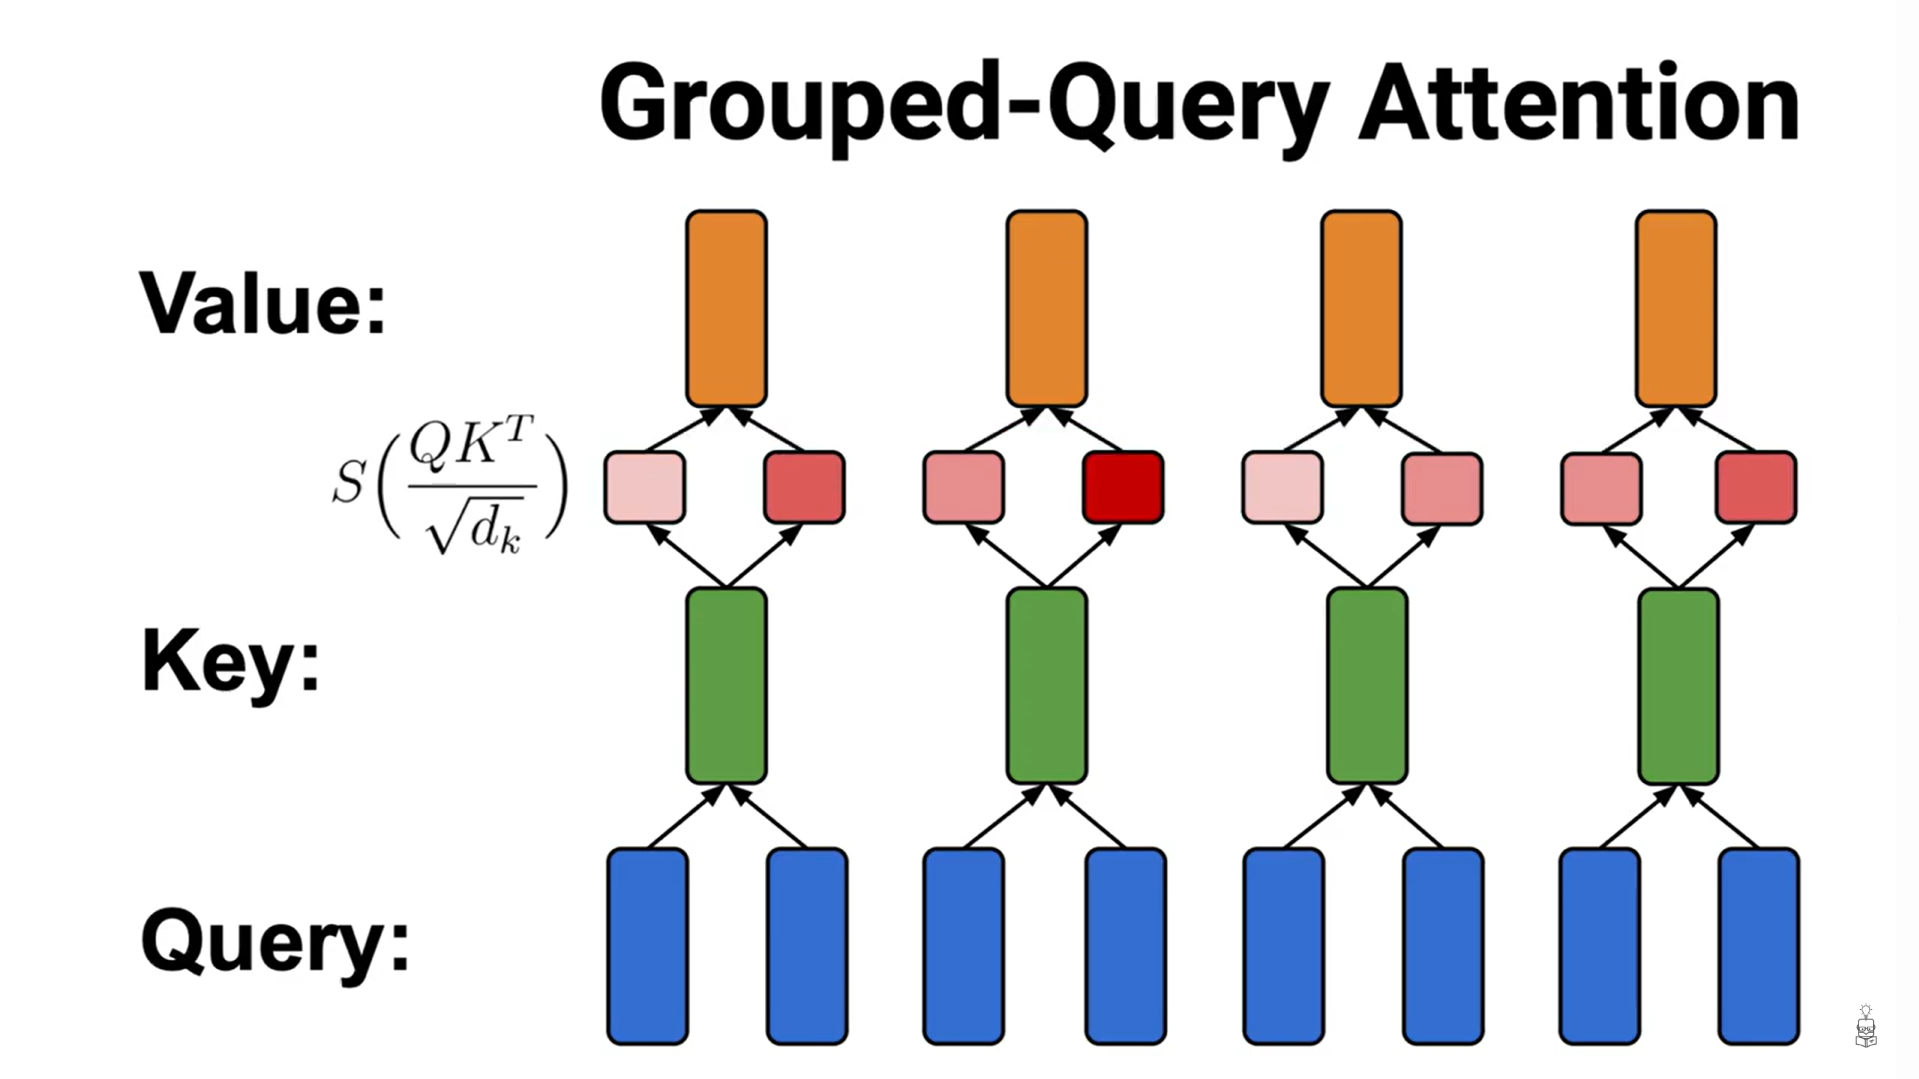

**Giải thích cơ chế hoạt động, ý tưởng chính**

**Ý tưởng chính**

**Grouped-Query Attention (GQA)** là một biến thể của **Multi-Head Attention (MHA)** trong **Transformer**, nằm giữa **MHA** và **Multi-Query Attention (MQA)**. **Ý tưởng chính**: Thay vì mỗi head có bộ **Query**, **Key**, **Value** riêng (như MHA) hoặc chia sẻ một **Key/Value** duy nhất (như MQA), GQA **chia các head thành các nhóm**, trong đó mỗi nhóm chia sẻ một bộ **Key** và **Value**, nhưng vẫn giữ **Query** riêng cho từng head trong nhóm. Điều này cân bằng giữa **hiệu suất tính toán**, **tiết kiệm bộ nhớ**, và **khả năng biểu diễn đa dạng** của các head.

**Cơ chế**

**GQA** hoạt động tương tự **MHA** nhưng với cơ chế chia nhóm:

1. Chuyển đổi (Projection)

Giả sử có \( h \) head, được chia thành \( g \) nhóm, mỗi nhóm có \( \frac{h}{g} \) head.  
Mỗi **embedding đầu vào** \( x_i \) sinh ra:
- **Query**:  
  $$ q_i^{\ell} = x_i W^Q_{\ell}, \quad \text{với } \ell = 1, \dots, h $$
- **Key**:  
  $$ k_i^m = x_i W^K_m, \quad \text{dùng chung cho nhóm thứ } m = 1, \dots, g $$
- **Value**:  
  $$ v_i^m = x_i W^V_m, \quad \text{dùng chung cho nhóm thứ } m $$

Kích thước ma trận:  
$$ W^Q_{\ell} \in \mathbb{R}^{d_{\text{model}} \times d_k}, \quad W^K_m, W^V_m \in \mathbb{R}^{d_{\text{model}} \times d_v} $$  
với $$ d_k = d_v = \frac{d_{\text{model}}}{h} $$.


2. Tính điểm chú ý (Scaled Dot-Product)

- Trong mỗi **nhóm** \( m \), mỗi **head** \( \ell \) thuộc nhóm tính **điểm chú ý**:
  $$
  \alpha_{ij}^{\ell} = \frac{q_i^{\ell} \cdot k_j^m}{\sqrt{d_k}}
  $$

3. Chuẩn hóa (Softmax)

- Chuẩn hóa **điểm chú ý** trên mỗi **head**:
  $$
  a_{ij}^{\ell} = \mathrm{softmax}_j(\alpha_{ij}^{\ell}) = \frac{\exp(\alpha_{ij}^{\ell})}{\sum_{t=1}^n \exp(\alpha_{it}^{\ell})}
  $$

4. Tổng hợp (Weighted Sum)

- Tính **đầu ra** cho mỗi **head**:
  $$
  z_i^{\ell} = \sum_{j=1}^n a_{ij}^{\ell} v_j^m
  $$
- Các **đầu ra** từ \( h \) **head** được ghép (**concatenate**) và chiếu qua ma trận \( W^O \in \mathbb{R}^{h \cdot d_v \times d_{\text{model}}} \):
  $$
  Z = \text{Concat}(z_i^1, \dots, z_i^h) W^O
  $$

5. Grouped-Query

- Thay vì \( h \) bộ **Key/Value** (như **MHA**) hoặc 1 bộ **Key/Value** (như **MQA**), **GQA** dùng \( g \) bộ **Key/Value**, mỗi bộ chia sẻ trong một **nhóm** \( h/g \) **head**, cân bằng giữa **tiết kiệm bộ nhớ** và **tính đa dạng biểu diễn**.

---

**Độ phức tạp tính toán**

Giả sử:
- Chuỗi đầu vào dài \( n \).
- Kích thước embedding \( d_{\text{model}} \).
- Có \( h \) head, chia thành \( g \) nhóm, mỗi nhóm có \( \frac{h}{g} \) head, với \( d_k = d_v = \frac{d_{\text{model}}}{h} \).

**1. Tính Q, K, V (Projection)**
- **Query**:  
  $$ O(n \cdot d_{\text{model}}^2) $$
- **Key và Value**:  
  $$ O(g \cdot n \cdot d_{\text{model}} \cdot d_k) $$

**2. Tính điểm chú ý (Scaled Dot-Product)**
$$ O(n^2 \cdot d_{\text{model}}) $$

**3. Chuẩn hóa (Softmax)**
$$ O(n^2) $$

**4. Tổng hợp (Weighted Sum)**
$$ O(n^2 \cdot d_{\text{model}}) $$

**5. Projection đầu ra**
$$ O(n \cdot d_{\text{model}}^2) $$

**Tóm lại**:
- **Thời gian**: $$ O(n^2 \cdot d_{\text{model}}) $$  
- **Bộ nhớ**: $$ O(g \cdot n \cdot d_k) $$

---

**Ưu điểm và hạn chế**

**Ưu điểm của Grouped-Query Attention**
- **Cân bằng giữa hiệu suất và biểu diễn**: **GQA** giữ được **tính đa dạng** của **MHA** (nhờ nhiều **Query**) nhưng tiết kiệm **bộ nhớ** hơn nhờ chia sẻ **Key/Value** trong nhóm.
- **Tiết kiệm bộ nhớ so với MHA**: Số lượng ma trận **Key/Value** giảm từ \( h \) xuống \( g \), giúp giảm bộ nhớ từ \( O(n \cdot h \cdot d_k) \) xuống \( O(n \cdot g \cdot d_k) \).
- **Tăng tốc suy luận**: Kết hợp với **KV caching**, **GQA** nhanh hơn **MHA** trong các mô hình **autoregressive**, đặc biệt khi \( g < h \).
- **Tính song song cao**: Vẫn tận dụng tốt **GPU/TPU** như **MHA** và **MQA**.
- **Linh hoạt**: Số **nhóm** \( g \) có thể điều chỉnh để cân bằng giữa **tiết kiệm bộ nhớ** (gần **MQA**) và **khả năng biểu diễn** (gần **MHA**).

**Hạn chế của Grouped-Query Attention**
- **Phức tạp hơn MQA**: **GQA** cần quản lý nhiều **nhóm Key/Value**, phức tạp hơn **MQA** (chỉ 1 bộ **Key/Value**).
- **Vẫn tốn bộ nhớ cho ma trận chú ý**: Ma trận **chú ý** tốn \( O(h \cdot n^2) \), không giải quyết được vấn đề khi \( n \) lớn.
- **Khả năng biểu diễn thấp hơn MHA**: Do chia sẻ **Key/Value** trong nhóm, **tính đa dạng** của **head** giảm so với **MHA**.
- **Phụ thuộc vào số nhóm \( g \)**: Hiệu quả của **GQA** phụ thuộc vào việc chọn \( g \). Nếu \( g \) quá nhỏ, gần **MQA**; nếu \( g \) lớn, gần **MHA**.

---

**So sánh với self-attention gốc trong Transformer**

$$
\begin{array}{|c|c|c|}
\hline
\textbf{Tiêu chí} & \textbf{Grouped-Query Attention (GQA)} & \textbf{Self-Attention gốc (Transformer)} \\
\hline
\textbf{Số head} & h \text{ head, chia thành } g \text{ nhóm, mỗi nhóm chia sẻ Key/Value} & h \text{ head, mỗi head có Query, Key, Value riêng} \\
\hline
\textbf{Projection (Q, K, V)} & h \text{ ma trận } W^Q_{\ell}, g \text{ ma trận } W^K_m, W^V_m & h \text{ ma trận } W^Q_{\ell}, W^K_{\ell}, W^V_{\ell} \\
\hline
\textbf{Scaled Dot-Product} & \alpha_{ij}^{\ell} = \frac{(q_i^{\ell})^\top k_j^{m}}{\sqrt{d_k}} & \alpha_{ij}^{\ell} = \frac{(q_i^{\ell})^\top k_j^{\ell}}{\sqrt{d_k}} \\
\hline
\textbf{Softmax \& Weighted Sum} & z_i^{\ell} = \sum_{j=1}^n a_{ij}^{\ell} v_j^{m} & z_i^{\ell} = \sum_{j=1}^n a_{ij}^{\ell} v_j^{\ell} \\
\hline
\textbf{Positional Encoding} & \text{Thường có, tương tự Transformer} & \text{Có: thêm positional encoding vào embedding đầu vào} \\
\hline
\textbf{Residual \& LayerNorm} & \text{Thường có, tương tự Transformer} & \text{Có: Residual + LayerNorm sau Multi-Head và Feed-Forward} \\
\hline
\textbf{Feed-Forward} & \text{Thường có, tương tự Transformer} & \text{Có: FFN sau mỗi block Attention} \\
\hline
\textbf{Đầu ra} & Z \in \mathbb{R}^{n \times d_{\text{model}}} \text{ (sau concat và } W^O \text{)} & Z \in \mathbb{R}^{n \times d_{\text{model}}} \text{ (sau concat và } W^O \text{)} \\
\hline
\textbf{Độ phức tạp (thời gian)} & O(n^2 \cdot d_{\text{model}}) & O(n^2 \cdot d_{\text{model}}) \\
\hline
\textbf{Độ phức tạp (bộ nhớ)} & O(n \cdot g \cdot d_k) \text{ cho K/V, } O(h \cdot n^2) \text{ cho ma trận chú ý} & O(n \cdot h \cdot d_k) \text{ cho K/V, } O(h \cdot n^2) \text{ cho ma trận chú ý} \\
\hline
\end{array}
$$

---

**Ứng dụng trong các mô hình LLM (large language model) hiện đại**

- GQA được sử dụng để **cân bằng giữa đa dạng head và tiết kiệm bộ nhớ** trong các mô hình ngôn ngữ lớn (LLM).
- Ví dụ: Một số biến thể của LLaMA, GPT và các mô hình hiệu năng cao có thể sử dụng GQA để tối ưu hóa suy luận mà vẫn giữ được khả năng biểu diễn đa dạng.
- Kết hợp với **KV caching theo nhóm**, GQA giúp tăng tốc độ sinh token autoregressive.
- Phù hợp với các mô hình có yêu cầu xử lý chuỗi dài mà MHA tốn bộ nhớ quá nhiều, còn MQA bị giảm biểu diễn.
- Có thể phối hợp với các kỹ thuật khác như Rotary Positional Embedding (RoPE), FlashAttention và Sparse Attention để tối ưu tổng thể.

###SpareAttention (Strided Attention)

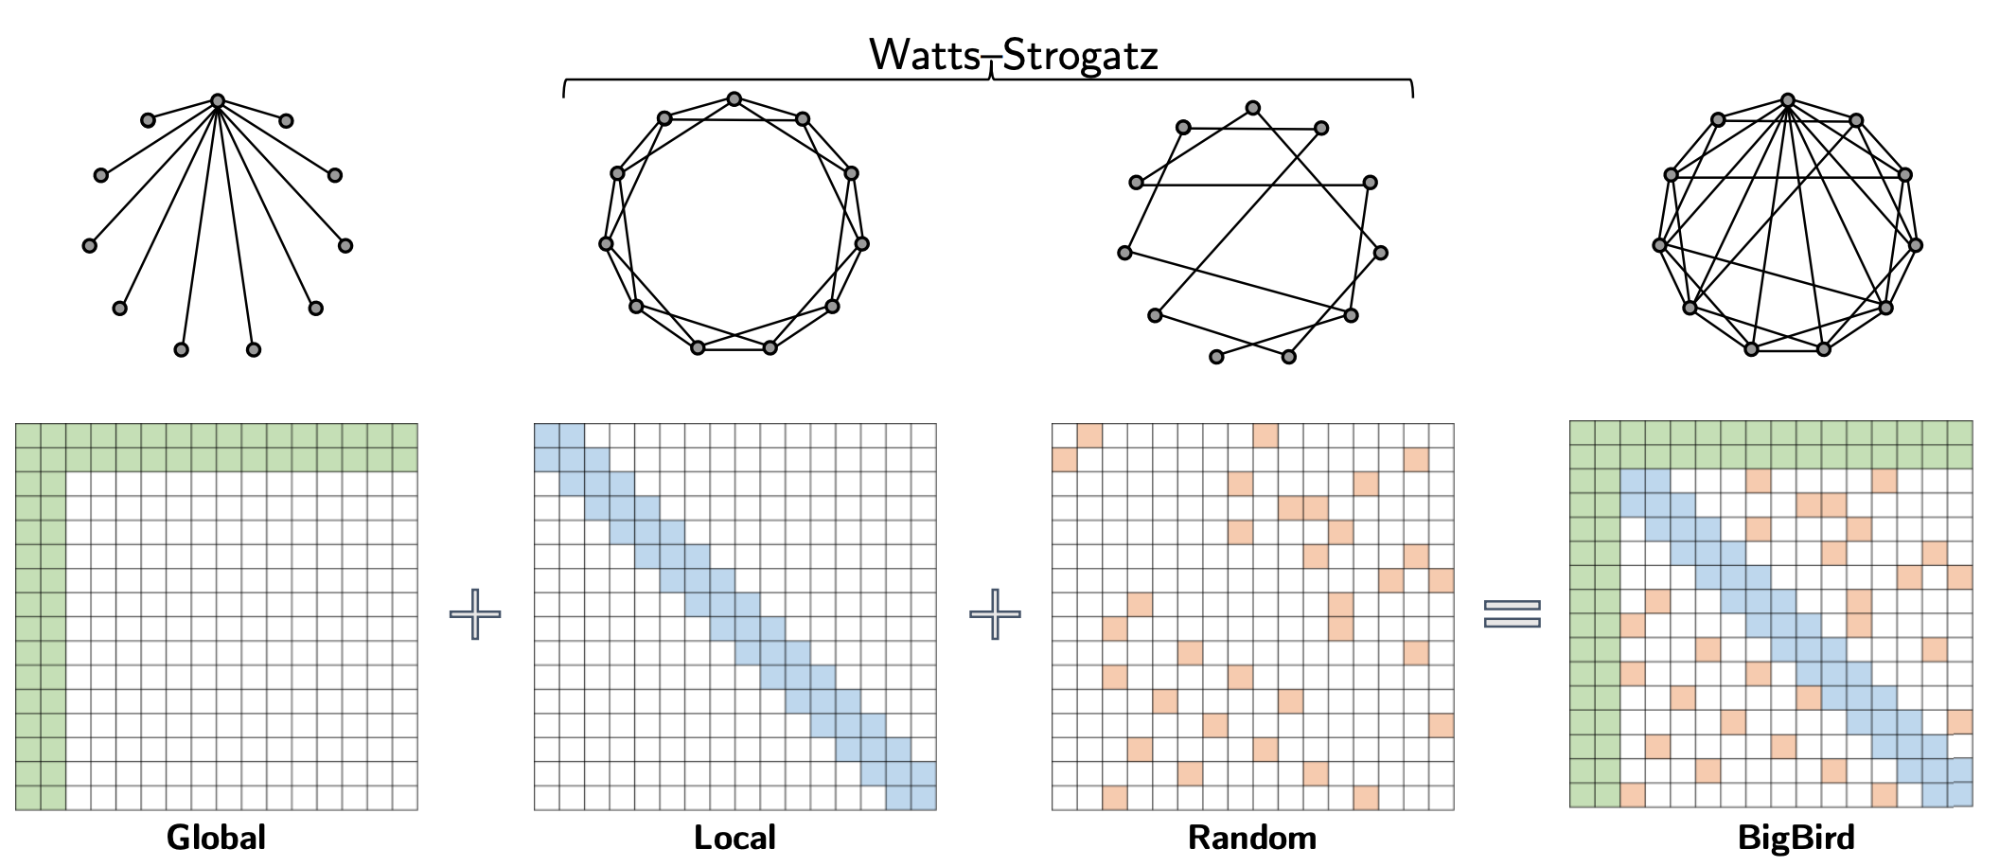

**Giải thích cơ chế hoạt động, ý tưởng chính**

Thay vì tính toán attention giữa một token Q và **tất cả** các token K trong chuỗi (dense attention), **Sparse Attention** chỉ tính toán attention giữa Q và một **tập con** các token K được chọn lọc.

* Ý tưởng chính là giả định rằng không phải tất cả các token đều quan trọng như nhau đối với một token cụ thể. Trong thực tế, sự phụ thuộc ngữ nghĩa thường có tính **cục bộ** hoặc tuân theo một **mẫu hình cụ thể**, do đó nhiều kết nối trong ma trận attention $N \times N$ có thể được **lược bỏ** mà không làm mất quá nhiều thông tin.

Một số **mẫu hình thưa (sparsity pattern)** phổ biến:

- **Local / Sliding Window Attention**: Mỗi token chỉ chú ý đến các token trong một cửa sổ lân cận cố định — phù hợp với giả định ngữ cảnh cục bộ.

- **Strided / Dilated Attention**: Mỗi token chú ý đến các token cách xa nó với khoảng cách là bội số của một stride $l$. Có thể kết hợp với attention cục bộ để vừa bao phủ gần, vừa bao phủ xa.

- **Fixed Patterns**: Các kết nối chú ý được xác định trước (ví dụ: trong mô hình **Longformer**).

- **Random Patterns**: Một số token được chọn ngẫu nhiên để chú ý, tăng khả năng bao phủ không gian.

- **Learned Patterns**: Dùng mạng con để học động xem token nào nên được chú ý.

- **Global Tokens**: Một vài token đặc biệt (như `[CLS]`) được phép chú ý đến toàn bộ các token khác và ngược lại.

---

**Độ phức tạp tính toán**

Trong khi **Dense Attention** có độ phức tạp thời gian và bộ nhớ là **$O(N^2)$**, thì các dạng **Sparse Attention** có thể giảm đáng kể chi phí này:

- **Local Attention** (cửa sổ cố định quanh mỗi token):  
  Mỗi token chỉ chú ý đến $w$ token gần nó (với $w \ll N$), nên độ phức tạp là:
  $$
  O(N \cdot w)
  $$

- **Strided Attention**:  
  Nếu chọn stride $l \approx \sqrt{N}$, thì mỗi token chú ý đến $\sqrt{N}$ token → tổng thể:
  $$
  O(N \cdot \sqrt{N}) = O(N^{1.5})
  $$

- **Kết hợp Local + Strided** (như trong Longformer):  
  Tăng khả năng bao phủ xa và gần, nhưng vẫn giữ chi phí thấp.

- **Các mô hình sparse khác (Fixed / Random / Learned)** có thể tối ưu thêm bằng cách thiết kế sparsity pattern phù hợp.

> **Tổng quát:** Tùy vào mẫu hình thưa và cách triển khai, độ phức tạp tính toán có thể giảm từ $O(N^2)$ xuống **$O(N \log N)$** hoặc thậm chí **$O(N)$**. Điều này cho phép mô hình **xử lý chuỗi dài hơn rất nhiều** mà vẫn

---

**Ưu điểm và hạn chế**

**Ưu điểm**

1. Hiệu quả tính toán cao

Trong cơ chế chú ý đầy đủ (Full Attention), mỗi token chú ý đến toàn bộ các token khác trong chuỗi, dẫn đến độ phức tạp thời gian và bộ nhớ là $O(n^2)$ — điều này **không khả thi với chuỗi rất dài** (hàng chục nghìn token trở lên).

**Strided Attention** khắc phục điều này bằng cách:
- Mỗi token chỉ chú ý đến **một tập con các vị trí**, được chọn theo bước nhảy cố định (stride).
- Khi kết hợp với chú ý cục bộ (Local Attention), mô hình vừa học được thông tin gần, vừa bao phủ được thông tin xa.

→ Nhờ đó, **độ phức tạp tính toán giảm xuống còn khoảng $O(n\sqrt{n})$**, **tiết kiệm đáng kể tài nguyên** về thời gian và bộ nhớ.

> **Ưu điểm nổi bật:**
> - Giảm đáng kể chi phí tính toán và bộ nhớ.
> - Cho phép mô hình xử lý **chuỗi rất dài** (hàng chục nghìn đến hàng trăm nghìn token).

---

2. Kết hợp hiệu quả ngữ cảnh cục bộ và dài hạn

Strided Attention thường được kết hợp với Local Attention để **khai thác đồng thời** hai loại ngữ cảnh:

- **Ngữ cảnh cục bộ**: Học các đặc trưng ngắn hạn như biên, họa tiết,...
- **Ngữ cảnh dài hạn**: Học các mối liên hệ xa, phát hiện mẫu lặp lại hoặc cấu trúc toàn cục.

Điều này giúp mô hình **cân bằng giữa việc hiểu chi tiết nhỏ và thông tin tổng thể**, từ đó cải thiện chất lượng biểu diễn và suy luận.

---

3. Tận dụng cấu trúc không gian

Khi áp dụng cho **dữ liệu không gian nhiều chiều** như ảnh (2D), voxel (3D), Strided Attention vẫn giữ được khả năng học các **mối quan hệ theo không gian** (hàng, cột, trục) ngay cả khi dữ liệu đã được tuyến tính hóa thành chuỗi.

-> Hữu ích trong việc phát hiện các **mẫu không gian có cấu trúc**, như:
- Đường thẳng
- Cạnh
- Khối

---

4. Khả năng mở rộng cho dữ liệu đa chiều

Strided Attention có thể được **áp dụng linh hoạt** cho các loại dữ liệu khác nhau:

- **Chuỗi 1D** (văn bản)
- **Dữ liệu 2D** (hình ảnh)
- **Dữ liệu 3D** (thể tích)

> Chỉ cần tuyến tính hóa dữ liệu đầu vào là có thể sử dụng, **không yêu cầu thay đổi lớn về kiến trúc** mô hình hiện có.

---

**Nhược điểm**

1. Mất mát thông tin từ các token không được chú ý

- Chỉ một phần nhỏ các token được chọn vào tập chú ý $A_i$, còn lại bị **bỏ qua**.
- Điều này dễ dẫn đến việc **bỏ lỡ các mối quan hệ quan trọng**, đặc biệt khi bài toán yêu cầu nắm bắt **ngữ cảnh toàn cục**.
- Có khả năng **làm mất thông tin do bỏ qua một số kết nối attention** quan trọng.

> 🧠 Kết luận: Strided Attention phù hợp với các tác vụ có cấu trúc đều đặn, nhưng dễ **suy giảm hiệu quả** nếu áp dụng cho tác vụ yêu cầu tổng hợp toàn bộ thông tin đầu vào.

---

2. Phụ thuộc vào tham số stride $l$ và mẫu hình thưa

- Việc chọn giá trị stride $l$ **không hợp lý** có thể ảnh hưởng tiêu cực đến hiệu quả mô hình:
  - $l$ **quá nhỏ** → phạm vi chú ý hẹp, mất thông tin toàn cục.
  - $l$ **quá lớn** → bỏ qua ngữ cảnh gần, tăng chi phí tính toán.

- **Hiệu suất phụ thuộc nhiều vào lựa chọn mẫu hình thưa**. Nếu mẫu không phù hợp với tác vụ → **không nắm bắt được các phụ thuộc tầm xa quan trọng**.

🛠️ Cần thử nghiệm và điều chỉnh tham số $l$ + sparsity pattern → **tốn thời gian và tài nguyên**.

---

3. Hạn chế trong việc học các mối quan hệ phức tạp

- Cơ chế stride cố định khiến mô hình chỉ học được **mối quan hệ tuyến tính** (theo hàng/cột/trục).
- Không linh hoạt với **mẫu không gian phức tạp**: chéo, cong, hoặc bất đối xứng.
- Giảm hiệu quả trong bài toán yêu cầu phát hiện **quan hệ phi tuyến tính** trong dữ liệu đầu vào.

---

4. Khó áp dụng cho dữ liệu không tuần hoàn

- Strided Attention **giả định** các token cách đều nhau đều mang thông tin hữu ích — điều này đúng với ảnh, nhưng **không đúng với văn bản** hoặc dữ liệu phi cấu trúc.
- Với dữ liệu **không tuần hoàn**, mối quan hệ giữa các token không phụ thuộc vào khoảng cách đều → dễ gây **suy giảm hiệu quả** trong NLP.

---

5. Triển khai phức tạp trên phần cứng

- Việc triển khai sparse attention (gồm cả Strided Attention) trên **GPU/TPU** có thể phức tạp hơn dense attention.
- Các phép toán ma trận không liên tục (non-contiguous access) cần kỹ thuật tối ưu đặc biệt, có thể **ảnh hưởng đến tốc độ suy luận (inference)** nếu không thiết kế cẩn thận.

> Tóm lại: Dù tiết kiệm tài nguyên, Strided Attention **yêu cầu thiết kế kỹ lưỡng** để tận dụng hiệu quả, và không phải là lựa chọn tối ưu cho mọi tác vụ.

---

**So sánh với self-attention gốc trong Transformer**

$$
\begin{array}{|c|c|c|}
\hline
\textbf{Tiêu chí} & \textbf{SpareAttention (Strided Attention)} & \textbf{Self-Attention gốc (Transformer)} \\
\hline
\textbf{Số head} & h \text{ head, sử dụng stride để giảm số lượng token tham chiếu} & h \text{ head, mỗi head có Query, Key, Value riêng} \\
\hline
\textbf{Cơ chế tính Attention} & \text{Chỉ tính Attention trên các token được chọn theo stride } s & \text{Tính Attention trên toàn bộ chuỗi đầu vào} \\
\hline
\textbf{Projection (Q, K, V)} & h \text{ ma trận } W^Q_{\ell}, g \text{ ma trận } W^K_m, W^V_m & h \text{ ma trận } W^Q_{\ell}, W^K_{\ell}, W^V_{\ell} \\
\hline
\textbf{Scaled Dot-Product} & \alpha_{ij}^{\ell} = \frac{(q_i^{\ell})^\top k_j^{m}}{\sqrt{d_k}}, \quad j \text{ thuộc tập chọn} & \alpha_{ij}^{\ell} = \frac{(q_i^{\ell})^\top k_j^{\ell}}{\sqrt{d_k}}, \quad j \text{ là toàn bộ chuỗi} \\
\hline
\textbf{Softmax \& Weighted Sum} & z_i^{\ell} = \sum_{j \in \text{stride}} a_{ij}^{\ell} v_j^{m} & z_i^{\ell} = \sum_{j=1}^n a_{ij}^{\ell} v_j^{\ell} \\
\hline
\textbf{Positional Encoding} & \text{Có thể cần điều chỉnh do stride làm mất thông tin vị trí} & \text{Có: thêm positional encoding vào embedding đầu vào} \\
\hline
\textbf{Residual \& LayerNorm} & \text{Thường có, tương tự Transformer} & \text{Có: Residual + LayerNorm sau Multi-Head và Feed-Forward} \\
\hline
\textbf{Feed-Forward} & \text{Thường có, tương tự Transformer} & \text{Có: FFN sau mỗi block Attention} \\
\hline
\textbf{Đầu ra} & Z \in \mathbb{R}^{n \times d_{\text{model}}}, \quad \text{nhưng với stride } s & Z \in \mathbb{R}^{n \times d_{\text{model}}} \text{ (sau concat và } W^O \text{)} \\
\hline
\textbf{Độ phức tạp (thời gian)} & O(n^2 / s \cdot d_{\text{model}}) & O(n^2 \cdot d_{\text{model}}) \\
\hline
\textbf{Độ phức tạp (bộ nhớ)} & O(n / s \cdot g \cdot d_k) \text{ cho K/V, } O(h \cdot (n/s)^2) \text{ cho ma trận chú ý} & O(n \cdot h \cdot d_k) \text{ cho K/V, } O(h \cdot n^2) \text{ cho ma trận chú ý} \\
\hline
\end{array}
$$

---

**Ứng dụng trong các mô hình LLM (large language model) hiện đại**

- Tăng tốc suy luận trong mô hình autoregressive
 - Giảm số lượng token cần xử lý tại mỗi bước, giúp giảm độ phức tạp từ  
  $$ O(n^2) $$  
  xuống  
  $$ O(n^2 / s) $$  
 - Được sử dụng trong các mô hình như **GPT-4, LLaMA, Grok** để tăng tốc tạo văn bản  
 - Tích hợp với **KV caching**, giúp cải thiện tốc độ xử lý ở chuỗi dài  

- Tối ưu hóa bộ nhớ trong inference trên thiết bị hạn chế
 - Giảm bộ nhớ từ  
  $$ O(n \cdot h \cdot d_k) $$  
  xuống  
  $$ O(n / s \cdot h \cdot d_k) $$  
 - Cho phép chạy **LLM trên thiết bị nhỏ** mà vẫn duy trì **độ chính xác cao**  
 - Hữu ích cho các ứng dụng **edge AI, di động, trình duyệt**  

- Xử lý ngữ cảnh dài trong LLM
 - Được dùng trong mô hình **Claude, Mistral, Grok-1.5** để xử lý văn bản dài hơn **100K tokens**  
 - Tối ưu truy xuất dữ liệu trong **retrieval-augmented generation (RAG)**  
 - Chỉ tính **Attention trên các vị trí quan trọng**, thay vì toàn bộ chuỗi  

- Ứng dụng trong mô hình đa phương thức (Multimodal LLM)
 - Giảm chi phí tính toán khi xử lý **ảnh và văn bản** trong **GPT-4V, Gemini**  
 - Tăng tốc phân tích **video** bằng cách **chỉ tính Attention trên keyframe quan trọng**  

- Tăng hiệu quả huấn luyện mô hình trên dữ liệu lớn
 - Giảm chi phí GPU bằng cách **hạn chế Attention trên toàn bộ tokens**  
 - Giúp **fine-tuning nhanh hơn** với **ít tài nguyên hơn**, tăng khả năng triển khai thực tế  

###Linear Attention

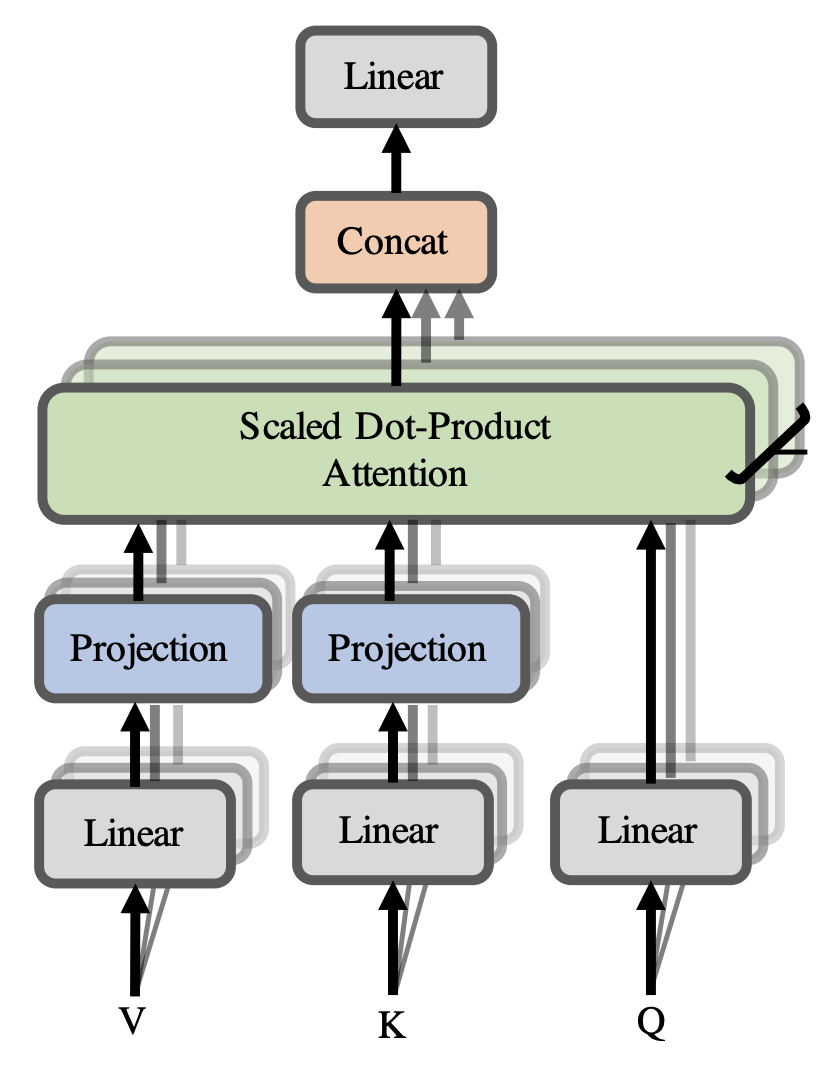

**Giải thích cơ chế hoạt động, ý tưởng chính**

Linear Attention là một biến thể của cơ chế Self-Attention trong mô hình Transformer, được thiết kế để giải quyết vấn đề độ phức tạp tính toán cao của Self-Attention truyền thống. Ý tưởng chính của Linear Attention là xấp xỉ phép tính attention thông qua các phép biến đổi kernel, cho phép tính toán với độ phức tạp tuyến tính theo độ dài chuỗi.

**Nguyên lý hoạt động:**

1. **Self-Attention truyền thống** tính toán ma trận attention thông qua công thức:
   $$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

2. **Linear Attention** áp dụng hàm biến đổi phi tuyến $\phi(x)$ cho các vector key và query:
   $$\text{LinearAttention}(Q, K, V) = \frac{\phi(Q) \cdot (\phi(K)^T \cdot V)}{\phi(Q) \cdot \phi(K)^T \cdot \mathbf{1}}$$

3. **Các hàm biến đổi phổ biến** cho $\phi(x)$:
   - ELU (Exponential Linear Unit): $\phi(x) = \text{ELU}(x) + 1$
   - ReLU (Rectified Linear Unit): $\phi(x) = \text{ReLU}(x)$
   - Softmax kernel: $\phi(x) = \text{exp}(x)$

4. **Thứ tự tính toán quan trọng:**
   - Tính $\phi(K)^T \cdot V$ trước
   - Sau đó nhân với $\phi(Q)$
   - Chuẩn hóa kết quả

---

**Độ phức tạp tính toán**

| Loại Attention | Độ phức tạp thời gian | Độ phức tạp không gian |
|----------------|------------------------|------------------------|
| Self-Attention | $O(n^2 \cdot d)$       | $O(n^2)$               |
| Linear Attention | $O(n \cdot d^2)$     | $O(n \cdot d)$         |

Trong đó:
- $n$: độ dài chuỗi (sequence length)
- $d$: chiều của vector biểu diễn (embedding dimension)

**Phân tích:**
- Với Self-Attention truyền thống, chúng ta phải tính toán ma trận $QK^T$ kích thước $(n \times n)$, dẫn đến độ phức tạp bậc hai theo độ dài chuỗi.
- Linear Attention tránh việc tính toán ma trận attention đầy đủ, thay vào đó phân tách phép tính để đạt được độ phức tạp tuyến tính theo $n$.

---

**Ưu điểm và hạn chế**

1. Ưu điểm:
- **Hiệu quả tính toán**: Giảm đáng kể độ phức tạp từ $O(n^2)$ xuống $O(n)$ theo độ dài chuỗi.
- **Tiết kiệm bộ nhớ**: Không cần lưu trữ ma trận attention đầy đủ kích thước $n \times n$.
- **Khả năng mở rộng**: Có thể xử lý chuỗi dài hơn nhiều so với self-attention truyền thống.
- **Không cần cơ chế masking phức tạp** cho một số biến thể.

2. Hạn chế:
- **Độ chính xác giảm**: Là phép xấp xỉ của self-attention, nên có thể mất đi một số khả năng mô hình hóa phụ thuộc phức tạp.
- **Hạn chế về biểu diễn**: Không phải mọi hàm kernel đều có thể biểu diễn được mối quan hệ tương tự như softmax.
- **Khó khăn khi huấn luyện**: Một số biến thể của Linear Attention có thể khó hội tụ hơn trong quá trình huấn luyện.
- **Tùy thuộc vào lựa chọn hàm phi tuyến**: Hiệu suất phụ thuộc nhiều vào việc lựa chọn hàm biến đổi $\phi$ phù hợp với dữ liệu.

---

**So sánh với self-attention gốc trong Transformer**

| Khía cạnh | Self-Attention gốc | Linear Attention |
|-----------|-------------------|-----------------|
| Độ phức tạp | $O(n^2 \cdot d)$ | $O(n \cdot d^2)$ |
| Khả năng mô hình hóa | Mạnh, có thể nắm bắt mối quan hệ phức tạp | Giảm đi, nhưng vẫn hiệu quả cho nhiều tác vụ |
| Độ dài chuỗi | Hạn chế (~1-2K tokens) | Có thể xử lý chuỗi dài hơn nhiều |
| Cơ chế hoạt động | Tạo ma trận attention đầy đủ | Xấp xỉ attention thông qua kernel tricks |
| Attention weights | Rõ ràng, dễ giải thích | Ngầm định, khó giải thích hơn |
| Hiệu quả với dữ liệu thưa | Tốt | Có thể kém hiệu quả hơn |
| Thực thi phần cứng | Tối ưu hóa tốt trên GPU hiện đại | Có thể ít được tối ưu hóa trên một số kiến trúc |

---

**Ứng dụng trong các mô hình LLM (large language model) hiện đại**

Linear Attention đã tìm được ứng dụng trong nhiều mô hình LLM hiện đại:

1. **Performers (Performer-Transformer)**: Sử dụng FAVOR+ (Fast Attention Via positive Orthogonal Random features), một dạng Linear Attention dựa trên xấp xỉ kernel với các tính năng ngẫu nhiên.

2. **Linformers**: Giảm độ phức tạp của self-attention bằng cách chiếu các ma trận key và value vào không gian thấp hơn.

3. **Linear Transformer**: Triển khai trực tiếp của ý tưởng Linear Attention, thay thế softmax bằng các hàm kernel tương đương.

4. **Reformer**: Kết hợp kỹ thuật hashing đa chiều để xấp xỉ self-attention với độ phức tạp gần tuyến tính.

5. **LongFormer và BigBird**: Mặc dù không hoàn toàn là Linear Attention, nhưng cũng giải quyết vấn đề độ phức tạp bậc hai bằng cách sử dụng attention thưa (sparse attention).

6. **Nyströmformer**: Sử dụng phương pháp Nyström để xấp xỉ ma trận attention với độ phức tạp tuyến tính.

7. **Hybrid models**: Các mô hình hiện đại như Mamba, RetNet, và một số LLM có cửa sổ context dài như Claude 3, GPT-4 Turbo, và Gemini thường kết hợp cả cơ chế attention truyền thống và các biến thể hiệu quả về tính toán như Linear Attention.

Linear Attention là một hướng nghiên cứu quan trọng trong việc mở rộng khả năng của các mô hình ngôn ngữ để xử lý chuỗi dài, cải thiện hiệu quả tính toán, và giảm yêu cầu về bộ nhớ, đặc biệt quan trọng khi các mô hình LLM ngày càng lớn và cần xử lý context dài hơn.

##Cài đặt mã nguồn minh họa (bằng PyTorch)

###Chuẩn bị dữ liệu AG‑News

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")   # WordPiece
max_len     = 64
num_labels  = 4
label_map   = {0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_text(text):
    """
    - Chuyển thành chữ thường
    - Loại bỏ ký tự đặc biệt
    - Chuẩn hoá khoảng trắng
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # loại bỏ ký tự không phải chữ/số
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)     # chuẩn hoá khoảng trắng
    return text

In [ ]:
def tokenize(example):
    out = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt",
    )
    example["input_ids"]      = out["input_ids"][0]
    example["attention_mask"] = out["attention_mask"][0]
    return example

In [ ]:
def preprocess_and_tokenize(example):
    txt = preprocess_text(example["text"])
    out = tokenizer(txt, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
    return {
        "input_ids": out["input_ids"][0],
        "attention_mask": out["attention_mask"][0],
        "label": example["label"],
    }

In [ ]:
raw_ds   = load_dataset("fancyzhx/ag_news")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
train_ds = raw_ds["train"].map(preprocess_and_tokenize, remove_columns=["text"]).shuffle(42)
test_ds  = raw_ds["test"].map(preprocess_and_tokenize, remove_columns=["text"])

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch",  columns=cols)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=128)
vocab_size = tokenizer.vocab_size

###Self-Attention

In [ ]:
class StandardSelfAttention(nn.Module):
    """Scaled‑Dot Self‑Attention gốc của Transformer"""
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim  = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim

        self.qkv_proj = nn.Linear(embed_dim, 3*embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout  = nn.Dropout(dropout)
        self.scale    = self.head_dim ** -0.5

    def forward(self, x, mask=None, return_attention=False):
        B, N, _ = x.size()

        qkv = self.qkv_proj(x).view(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2,0,3,1,4)                       # [3,B,H,N,D]
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = torch.matmul(q, k.transpose(-2,-1)) * self.scale   # [B,H,N,N]
        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out  = torch.matmul(attn, v)                       # [B,H,N,D]
        out  = out.transpose(1,2).contiguous().view(B,N,self.embed_dim)
        out  = self.out_proj(out)

        if return_attention:
            return out, attn
        return out

###Multi-Query Attention (MQA)

In [ ]:
class MultiQueryAttention(nn.Module):
    """MQA – nhiều Query, chung Key/Value"""
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim  = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, self.head_dim)
        self.v_proj = nn.Linear(embed_dim, self.head_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout  = nn.Dropout(dropout)
        self.scale    = self.head_dim ** -0.5

    def forward(self, x, mask=None, return_attention=False):
        B, N, _ = x.size()
        q = self.q_proj(x).view(B,N,self.num_heads,self.head_dim).permute(0,2,1,3)  # [B,H,N,D]
        k = self.k_proj(x).view(B,N,1,self.head_dim).permute(0,2,1,3)               # [B,1,N,D]
        v = self.v_proj(x).view(B,N,1,self.head_dim).permute(0,2,1,3)               # [B,1,N,D]

        scores = torch.matmul(q, k.transpose(-2,-1)) * self.scale                   # [B,H,N,N]
        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out  = torch.matmul(attn, v.expand(-1,self.num_heads,-1,-1))                # [B,H,N,D]
        out  = out.transpose(1,2).contiguous().view(B,N,self.embed_dim)
        out  = self.out_proj(out)

        if return_attention:
            return out, attn
        return out

###Grouped-Query Attention (GQA)

In [ ]:
class GroupedQueryAttention(nn.Module):
    """GQA – nhóm nhiều head Query chia sẻ cùng Key/Value"""
    def __init__(self, embed_dim, num_heads, num_kv_heads, dropout=0.0):
        super().__init__()
        assert num_heads % num_kv_heads == 0
        self.embed_dim      = embed_dim
        self.num_heads      = num_heads
        self.num_kv_heads   = num_kv_heads
        self.head_dim       = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim

        self.q_proj  = nn.Linear(embed_dim, embed_dim)
        self.k_proj  = nn.Linear(embed_dim, self.head_dim * num_kv_heads)
        self.v_proj  = nn.Linear(embed_dim, self.head_dim * num_kv_heads)
        self.out_proj= nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale   = self.head_dim ** -0.5
        self.q_per_k = num_heads // num_kv_heads

    def forward(self, x, mask=None, return_attention=False):
        B, N, _ = x.size()
        q = self.q_proj(x).view(B,N,self.num_heads,self.head_dim).permute(0,2,1,3)  # [B,H,N,D]
        k = self.k_proj(x).view(B,N,self.num_kv_heads,self.head_dim).permute(0,2,1,3)
        v = self.v_proj(x).view(B,N,self.num_kv_heads,self.head_dim).permute(0,2,1,3)

        k = torch.repeat_interleave(k, self.q_per_k, dim=1)   # [B,H,N,D]
        v = torch.repeat_interleave(v, self.q_per_k, dim=1)

        scores = torch.matmul(q, k.transpose(-2,-1)) * self.scale                 # [B,H,N,N]
        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out  = torch.matmul(attn, v)                                              # [B,H,N,D]
        out  = out.transpose(1,2).contiguous().view(B,N,self.embed_dim)
        out  = self.out_proj(out)

        if return_attention:
            return out, attn
        return out

###SpareAttention

In [ ]:
class SparseAttention(nn.Module):
    """Sparse (strided) Attention mang tính minh hoạ"""
    def __init__(self, embed_dim, num_heads, stride=2, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim  = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim
        self.stride     = stride
        self.qkv_proj   = nn.Linear(embed_dim, 3*embed_dim)
        self.out_proj   = nn.Linear(embed_dim, embed_dim)
        self.dropout    = nn.Dropout(dropout)
        self.scale      = self.head_dim ** -0.5

    def forward(self, x, mask=None, return_attention=False):
        B, N, _ = x.size()
        qkv = self.qkv_proj(x).view(B,N,3,self.num_heads,self.head_dim)
        qkv = qkv.permute(2,0,3,1,4)                      # [3,B,H,N,D]
        q,k,v = qkv[0], qkv[1], qkv[2]

        scores = torch.matmul(q, k.transpose(-2,-1)) * self.scale  # [B,H,N,N]

        # stride mask
        sparse = torch.full((N,N), float('-inf'), device=x.device)
        for i in range(N):
            for j in range(i, -1, -self.stride): sparse[i,j]=0
            for j in range(i, N,  self.stride): sparse[i,j]=0
        scores = scores + sparse.unsqueeze(0).unsqueeze(0)

        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out  = torch.matmul(attn, v).transpose(1,2).contiguous().view(B,N,self.embed_dim)
        out  = self.out_proj(out)

        if return_attention:
            return out, attn
        return out

###Linear Attention

In [ ]:
class LinearAttention(nn.Module):
    """Linear Attention (ELU feature map)"""
    def __init__(self, embed_dim, num_heads=1, eps=1e-6, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim  = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim

        self.qkv_proj = nn.Linear(embed_dim, 3*embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout  = nn.Dropout(dropout)
        self.eps      = eps

    def _phi(self, x):          # ELU + 1 feature map
        return F.elu(x)+1

    def forward(self, x, mask=None, return_attention=False):
        B,N,E = x.size()
        H,D   = self.num_heads, self.head_dim

        qkv = self.qkv_proj(x).view(B,N,3,H,D).permute(2,0,3,1,4)   # [3,B,H,N,D]
        q,k,v = self._phi(qkv[0]), self._phi(qkv[1]), qkv[2]

        kv = torch.einsum('bhnd,bhne->bhde', k, v)          # [B,H,D,D]
        z  = torch.einsum('bhnd->bhd', k) + self.eps        # [B,H,D]
        out= torch.einsum('bhnd,bhde->bhne', q, kv)         # [B,H,N,D]
        denom = torch.einsum('bhnd,bhd->bhn', q, z)         # [B,H,N]
        out  = out / denom.unsqueeze(-1)
        out  = out.transpose(1,2).contiguous().view(B,N,E)
        out  = self.out_proj(out)

        if return_attention:
            # tái dựng softmax‑attention để visualize (chậm nhưng chỉ dùng khi cần)
            scores = torch.einsum('bhnd,bhmd->bhnm', q, k)          # [B,H,N,N]
            if mask is not None:
                scores = scores.masked_fill(mask==0, float('-inf'))
            attn = F.softmax(scores, dim=-1)
            attn = self.dropout(attn)
            return out, attn
        return out

###Classifier khung chung

In [ ]:
class AttentionClassifier(nn.Module):
    def __init__(self, attn_cls, *, embed_dim=128, num_heads=8,
                 num_classes=num_labels, **attn_kwargs):
        super().__init__()
        self.embed   = nn.Embedding(vocab_size, embed_dim)
        self.attn    = attn_cls(embed_dim, num_heads, **attn_kwargs)
        self.pool    = nn.AdaptiveAvgPool1d(1)
        self.linear  = nn.Linear(embed_dim, num_classes)

    def forward(self, ids, mask=None, return_attention=False):
        x = self.embed(ids)                       # [B,N,E]
        if return_attention:
            x, attn = self.attn(x, mask, True)    # trả về attention
        else:
            x      = self.attn(x, mask)
        x = self.pool(x.transpose(1,2)).squeeze(-1)
        logits = self.linear(x)
        return (logits, attn) if return_attention else logits

###Train / Eval utilities

In [ ]:
@torch.no_grad()
def accuracy(model, dl):
    model.eval()
    preds, golds = [], []
    for batch in dl:
        ids  = batch["input_ids"].to(device)
        mask = batch["attention_mask"].unsqueeze(1).unsqueeze(2).to(device)
        y    = batch["label"].cpu().tolist()
        logits = model(ids, mask)
        preds.extend(logits.argmax(-1).cpu().tolist())
        golds.extend(y)
    return accuracy_score(golds, preds)

In [ ]:
def quick_train(model, epochs=10):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=2e-4)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(1,epochs+1):
        model.train()
        for batch in tqdm(train_dl, leave=False, desc=f"Epoch {ep}/{epochs}"):
            ids  = batch["input_ids"].to(device)
            mask = batch["attention_mask"].unsqueeze(1).unsqueeze(2).to(device)
            y    = batch["label"].to(device)

            logits = model(ids, mask)
            loss   = loss_fn(logits, y)

            opt.zero_grad(); loss.backward(); opt.step()

        print(f"Epoch {ep:2d}: Train Acc = {accuracy(model,train_dl):.4f} | "
              f"Test Acc = {accuracy(model,test_dl):.4f}")

### Hàm tính độ quan trọng token

In [ ]:
def token_importance(attn, num_heads):
    """
    attn : Tensor attention [B,H,N,N]  hoặc  [B,N,N,H]
    Trả về: numpy vector độ quan trọng có chiều N (seq_len)
    """
    if attn.dim() != 4:
        raise ValueError("attention tensor phải 4 chiều")
    # heads ở trục 1?
    if attn.shape[1] == num_heads:
        imp = attn.mean(dim=1)[0].mean(dim=-1).cpu().numpy()  # [N]
    # heads ở trục cuối?
    elif attn.shape[-1] == num_heads:
        imp = attn.mean(dim=-1)[0].mean(dim=0).cpu().numpy()  # [N]
    else:
        raise ValueError("Không xác định được trục heads trong attention tensor")
    return imp

###Chạy thử với 5 biến thể Attention

In [ ]:
attn_variants = [
    ("Standard",    StandardSelfAttention, {}),
    ("Multi‑Query", MultiQueryAttention,   {}),
    ("Grouped",     GroupedQueryAttention, {"num_kv_heads":2}),
    ("Sparse",      SparseAttention,       {"stride":2}),
    ("Linear",      LinearAttention,       {}),
]

In [ ]:
TOP_K         = 10                      # ① ——> đổi 10 → 5
all_samples   = defaultdict(list)
all_attn_maps = defaultdict(list)
all_accs      = {}

In [ ]:
def topk_tokens(imp, tokens, k=5):
    """Trả về 2 list: top-k index và top-k token (đã filter [SEP], '##')."""
    idx_sorted = np.argsort(imp)[::-1]
    sel_idx, sel_tok = [], []
    for i in idx_sorted:
        tok = tokens[i]
        if tok == "[SEP]" or tok.startswith("##"):
            continue
        sel_idx.append(i)
        sel_tok.append(tok)
        if len(sel_idx) == k:
            break
    return sel_idx, sel_tok

In [ ]:
# ---------- vòng lặp qua các biến thể attention ----------
for name, cls, kwargs in attn_variants:
    print(f"\n===== {name} =====")
    model = AttentionClassifier(cls, embed_dim=128, num_heads=4,
                                dropout=0.1, **kwargs).to(device)
    quick_train(model, epochs=10)
    test_acc       = accuracy(model, test_dl)
    all_accs[name] = test_acc
    print(f"{name} Test Acc = {test_acc:.4f}")

    # ========== SAMPLE #0 (in ma trận + top-10 tokens) ==========
    idx0     = 0
    sample   = test_ds[idx0]
    ids_s    = sample["input_ids"].unsqueeze(0).to(device)
    mask_s   = sample["attention_mask"].unsqueeze(0).unsqueeze(1).unsqueeze(2).to(device)

    model.eval()
    with torch.no_grad():
        logits, attn = model(ids_s, mask_s, return_attention=True)

    attn_map = attn.squeeze(0).mean(0).cpu().numpy()
    tokens   = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())

    # tính importance + mask PAD
    imp = token_importance(attn, model.attn.num_heads)
    imp[sample["attention_mask"].numpy() == 0] = -np.inf

    # lấy top-10 tokens
    _, top10 = topk_tokens(imp, tokens, k=TOP_K)

    # in ra
    raw_text = raw_ds["test"][idx0]["text"]
    y_true   = sample["label"].item()
    y_pred   = logits.argmax(-1).item()

    print(f"\nRAW  : {raw_text}")
    print(f"TRUE : {label_map[y_true]} | PRED: {label_map[y_pred]}")
    print("Top-10 tokens:")
    print("  " + " | ".join(top10))

    print("\nAttention map (averaged over heads):")
    np.set_printoptions(precision=3, suppress=True, linewidth=120)
    print(np.round(attn_map, 3))

    all_samples[name].append((raw_text, y_true, y_pred, top5))
    all_attn_maps[name].append(attn_map)

    # ========== 4 SAMPLE NGẪU NHIÊN (chỉ top-10 tokens) ==========
    rand_idxs = random.sample(range(1, len(test_ds)), 4)
    for idx in rand_idxs:
        sample = test_ds[idx]
        ids_s  = sample["input_ids"].unsqueeze(0).to(device)
        mask_s = sample["attention_mask"].unsqueeze(0).unsqueeze(1).unsqueeze(2).to(device)

        with torch.no_grad():
            logits, attn = model(ids_s, mask_s, return_attention=True)

        imp = token_importance(attn, model.attn.num_heads)
        imp[sample["attention_mask"].numpy() == 0] = -np.inf

        tokens       = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
        _, top10_rand = topk_tokens(imp, tokens, k=TOP_K)

        raw_text = raw_ds["test"][idx]["text"]
        y_true   = sample["label"].item()
        y_pred   = logits.argmax(-1).item()

        print(f"\nRAW  : {raw_text[:120]}…")
        print(f"TRUE : {label_map[y_true]} | PRED: {label_map[y_pred]}")
        print("Top-10 tokens:")
        print("  " + " | ".join(top10_rand))

        all_samples[name].append((raw_text, y_true, y_pred, top10_rand))


===== Standard =====


Epoch  1: Train Acc = 0.8306 | Test Acc = 0.8203


Epoch  2: Train Acc = 0.8675 | Test Acc = 0.8559


Epoch  3: Train Acc = 0.8846 | Test Acc = 0.8712


Epoch  4: Train Acc = 0.8990 | Test Acc = 0.8801


Epoch  5: Train Acc = 0.9076 | Test Acc = 0.8843


Epoch  6: Train Acc = 0.9150 | Test Acc = 0.8908


Epoch  7: Train Acc = 0.9207 | Test Acc = 0.8921


Epoch  8: Train Acc = 0.9266 | Test Acc = 0.8968


Epoch  9: Train Acc = 0.9308 | Test Acc = 0.8953


Epoch 10: Train Acc = 0.9348 | Test Acc = 0.8983
Standard Test Acc = 0.8983

RAW  : Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
TRUE : Business | PRED: World
Top-10 tokens:
  say | new | turner | talks | fears | for | t | unions | representing | workers

Attention map (averaged over heads):
[[0.007 0.025 0.003 ... 0.    0.    0.   ]
 [0.06  0.037 0.032 ... 0.    0.    0.   ]
 [0.016 0.007 0.002 ... 0.    0.    0.   ]
 ...
 [0.109 0.066 0.027 ... 0.    0.    0.   ]
 [0.109 0.066 0.027 ... 0.    0.    0.   ]
 [0.109 0.066 0.027 ... 0.    0.    0.   ]]

RAW  : Cisco joins WiMax Forum The networking giant formally signs on to the wireless broadband group as the organization's ran…
TRUE : Sci/Tech | PRED: Sci/Tech
Top-10 tokens:
  to | the | formally | on | forum | the | networking | wi | joins | increase

RAW  : DreamWorks Animation IPO may raise up to \$725M Animated film-

Epoch  1: Train Acc = 0.8095 | Test Acc = 0.8050


Epoch  2: Train Acc = 0.8569 | Test Acc = 0.8488


Epoch  3: Train Acc = 0.8765 | Test Acc = 0.8634


Epoch  4: Train Acc = 0.8914 | Test Acc = 0.8736


Epoch  5: Train Acc = 0.9002 | Test Acc = 0.8793


Epoch  6: Train Acc = 0.9089 | Test Acc = 0.8870


Epoch  7: Train Acc = 0.9147 | Test Acc = 0.8899


Epoch  8: Train Acc = 0.9210 | Test Acc = 0.8947


Epoch  9: Train Acc = 0.9260 | Test Acc = 0.8974


Epoch 10: Train Acc = 0.9298 | Test Acc = 0.8979
Multi‑Query Test Acc = 0.8979

RAW  : Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
TRUE : Business | PRED: World
Top-10 tokens:
  say | new | they | talks | are | n | [CLS] | talks | after | representing

Attention map (averaged over heads):
[[0.003 0.001 0.001 ... 0.    0.    0.   ]
 [0.034 0.032 0.025 ... 0.    0.    0.   ]
 [0.016 0.014 0.008 ... 0.    0.    0.   ]
 ...
 [0.076 0.022 0.01  ... 0.    0.    0.   ]
 [0.076 0.022 0.01  ... 0.    0.    0.   ]
 [0.076 0.022 0.01  ... 0.    0.    0.   ]]

RAW  : Minaya ahead in count even if he strikes out This is the way Mets fans wanted their team to do it with Vladimir Guerrero…
TRUE : Sports | PRED: Sports
Top-10 tokens:
  of | it | the | phillips | steve | or | general | to | jim | du

RAW  : US Supreme Court to Decide Grokster Case The US Supreme Court on Friday agreed t

Epoch  1: Train Acc = 0.8123 | Test Acc = 0.8058


Epoch  2: Train Acc = 0.8591 | Test Acc = 0.8470


Epoch  3: Train Acc = 0.8801 | Test Acc = 0.8641


Epoch  4: Train Acc = 0.8926 | Test Acc = 0.8717


Epoch  5: Train Acc = 0.9032 | Test Acc = 0.8829


Epoch  6: Train Acc = 0.9105 | Test Acc = 0.8878


Epoch  7: Train Acc = 0.9166 | Test Acc = 0.8889


Epoch  8: Train Acc = 0.9219 | Test Acc = 0.8939


Epoch  9: Train Acc = 0.9267 | Test Acc = 0.8934


Epoch 10: Train Acc = 0.9306 | Test Acc = 0.8975
Grouped Test Acc = 0.8975

RAW  : Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
TRUE : Business | PRED: Business
Top-10 tokens:
  say | new | turner | at | representing | workers | disappointed | they | parent | unions

Attention map (averaged over heads):
[[0.047 0.01  0.053 ... 0.    0.    0.   ]
 [0.039 0.046 0.055 ... 0.    0.    0.   ]
 [0.025 0.018 0.052 ... 0.    0.    0.   ]
 ...
 [0.16  0.017 0.009 ... 0.    0.    0.   ]
 [0.16  0.017 0.009 ... 0.    0.    0.   ]
 [0.16  0.017 0.009 ... 0.    0.    0.   ]]

RAW  : Iraqi Forces Foundering in Face of Killings and Threats by Rebels Iraqi forces, whose performance is crucial to securing…
TRUE : World | PRED: World
Top-10 tokens:
  threats | crucial | performance | in | face | forces | of | and | by | rebels

RAW  : Hurricane Ivan again growing in strength, Caribbean is

Epoch  1: Train Acc = 0.8292 | Test Acc = 0.8239


Epoch  2: Train Acc = 0.8677 | Test Acc = 0.8567


Epoch  3: Train Acc = 0.8868 | Test Acc = 0.8700


Epoch  4: Train Acc = 0.8975 | Test Acc = 0.8778


Epoch  5: Train Acc = 0.9063 | Test Acc = 0.8821


Epoch  6: Train Acc = 0.9132 | Test Acc = 0.8862


Epoch  7: Train Acc = 0.9203 | Test Acc = 0.8889


Epoch  8: Train Acc = 0.9245 | Test Acc = 0.8908


Epoch  9: Train Acc = 0.9304 | Test Acc = 0.8925


Epoch 10: Train Acc = 0.9343 | Test Acc = 0.8947
Sparse Test Acc = 0.8947

RAW  : Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
TRUE : Business | PRED: Business
Top-10 tokens:
  pension | parent | new | say | at | they | fears | turner | representing | workers

Attention map (averaged over heads):
[[0.01  0.    0.025 ... 0.    0.    0.   ]
 [0.    0.051 0.    ... 0.    0.    0.   ]
 [0.026 0.    0.038 ... 0.    0.    0.   ]
 ...
 [0.    0.009 0.    ... 0.    0.    0.   ]
 [0.159 0.    0.107 ... 0.    0.    0.   ]
 [0.    0.009 0.    ... 0.    0.    0.   ]]

RAW  : Mammoth toxic algae bloom sighted off Washington state coast SEATTLE - A toxic algae bloom 30 miles wide has been detect…
TRUE : Sci/Tech | PRED: Sci/Tech
Top-10 tokens:
  scientists | by | yet | lethal | most | potentially | and | in | region | seattle

RAW  : Paralympics: China Surges As First Doping Cases Res

Epoch  1: Train Acc = 0.8153 | Test Acc = 0.8020


Epoch  2: Train Acc = 0.8625 | Test Acc = 0.8430


Epoch  3: Train Acc = 0.8810 | Test Acc = 0.8605


Epoch  4: Train Acc = 0.8966 | Test Acc = 0.8714


Epoch  5: Train Acc = 0.9057 | Test Acc = 0.8801


Epoch  6: Train Acc = 0.9126 | Test Acc = 0.8871


Epoch  7: Train Acc = 0.9183 | Test Acc = 0.8895


Epoch  8: Train Acc = 0.9228 | Test Acc = 0.8928


Epoch  9: Train Acc = 0.9272 | Test Acc = 0.8955


Epoch 10: Train Acc = 0.9316 | Test Acc = 0.8971
Linear Test Acc = 0.8971

RAW  : Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
TRUE : Business | PRED: Business
Top-10 tokens:
  fears | parent | turner | say | talks | after | t | they | at | unions

Attention map (averaged over heads):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

RAW  : ElBaradei strongly rejects charges of collaboration with Iran International Atomic Energy Agency (IAEA) Director-General…
TRUE : World | PRED: World
Top-10 tokens:
  reports | investigation | releasing | collaborated | of | with | iran | ahead | nuclear | tehran

RAW  : Cricket: Dubai global academy The International Cricket Council are to open a global cricket academy designed to improve…
TRUE : World | PRED: World
Top-10 tokens

###Biểu đồ

In [ ]:
# Số epoch
epochs = list(range(1, 11))

train_acc = {
    "Standard":    [0.8306, 0.8675, 0.8846, 0.8990, 0.9076, 0.9150, 0.9207, 0.9266, 0.9308, 0.9348],
    "Multi-Query": [0.8095, 0.8569, 0.8765, 0.8914, 0.9002, 0.9089, 0.9147, 0.9210, 0.9260, 0.9298],
    "Grouped":     [0.8123, 0.8591, 0.8801, 0.8926, 0.9032, 0.9105, 0.9166, 0.9219, 0.9267, 0.9306],
    "Sparse":      [0.8292, 0.8677, 0.8868, 0.8975, 0.9063, 0.9132, 0.9203, 0.9245, 0.9304, 0.9343],
    "Linear":      [0.8153, 0.8625, 0.8810, 0.8966, 0.9057, 0.9126, 0.9183, 0.9228, 0.9272, 0.9316],
}

# Dữ liệu test accuracy
test_acc = {
    "Standard":    [0.8203, 0.8559, 0.8712, 0.8801, 0.8843, 0.8908, 0.8921, 0.8968, 0.8953, 0.8983],
    "Multi-Query": [0.8050, 0.8488, 0.8634, 0.8736, 0.8793, 0.8870, 0.8899, 0.8947, 0.8974, 0.8979],
    "Grouped":     [0.8058, 0.8470, 0.8641, 0.8717, 0.8829, 0.8878, 0.8889, 0.8939, 0.8934, 0.8975],
    "Sparse":      [0.8239, 0.8567, 0.8700, 0.8778, 0.8821, 0.8862, 0.8889, 0.8908, 0.8925, 0.8947],
    "Linear":      [0.8020, 0.8430, 0.8605, 0.8714, 0.8801, 0.8871, 0.8895, 0.8928, 0.8955, 0.8971],
}

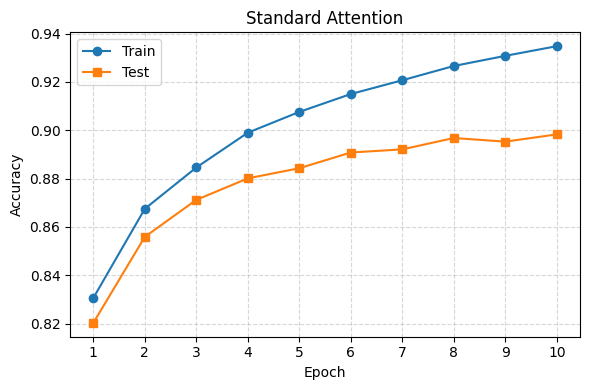

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(epochs, train_acc["Standard"], marker='o', label="Train")
ax.plot(epochs, test_acc["Standard"],  marker='s', label="Test")
ax.set_title("Standard Attention")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_xticks(epochs)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

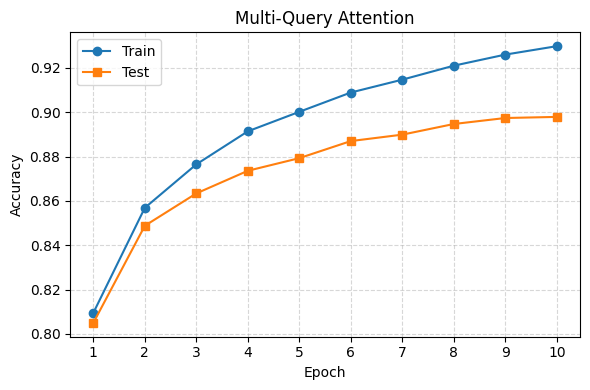

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(epochs, train_acc["Multi-Query"], marker='o', label="Train")
ax.plot(epochs, test_acc["Multi-Query"],  marker='s', label="Test")
ax.set_title("Multi-Query Attention")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_xticks(epochs)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

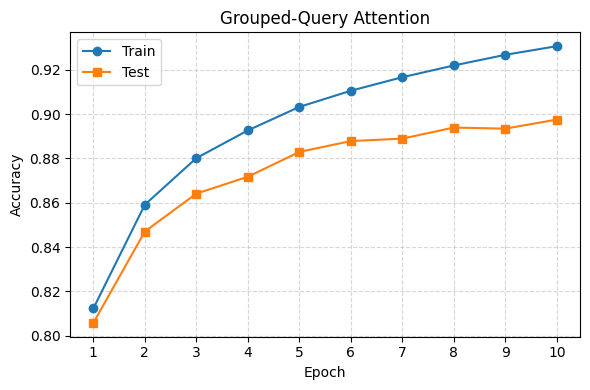

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(epochs, train_acc["Grouped"], marker='o', label="Train")
ax.plot(epochs, test_acc["Grouped"],  marker='s', label="Test")
ax.set_title("Grouped-Query Attention")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_xticks(epochs)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

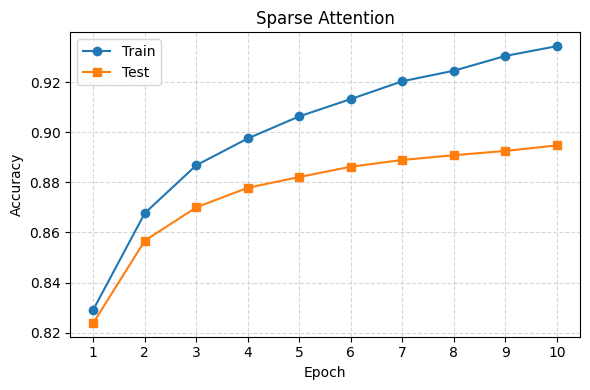

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(epochs, train_acc["Sparse"], marker='o', label="Train")
ax.plot(epochs, test_acc["Sparse"],  marker='s', label="Test")
ax.set_title("Sparse Attention")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_xticks(epochs)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

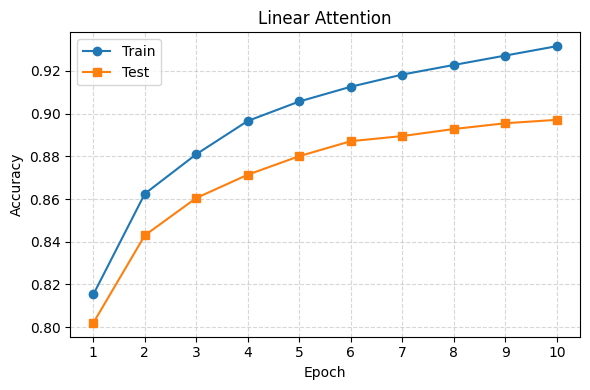

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(epochs, train_acc["Linear"], marker='o', label="Train")
ax.plot(epochs, test_acc["Linear"],  marker='s', label="Test")
ax.set_title("Linear Attention")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_xticks(epochs)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

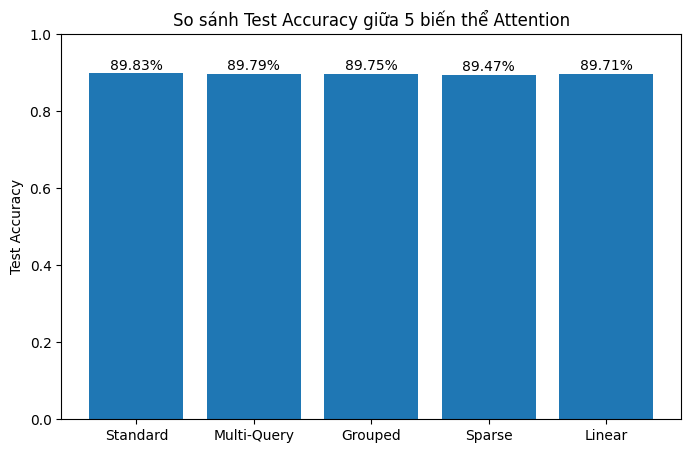

In [ ]:
plt.figure(figsize=(8,5))
names = list(all_accs.keys())
accs  = [all_accs[n] for n in names]
plt.bar(names, accs)
plt.ylim(0,1)
plt.ylabel("Test Accuracy")
plt.title("So sánh Test Accuracy giữa 5 biến thể Attention")
for i,v in enumerate(accs):
    plt.text(i, v+0.01, f"{v:.2%}", ha="center")
plt.show()

#Bài 2: Xây dựng mô hình trích xuất văn bản từ ảnh bằng mô hình kết hợp CNN và Transformer-Decoder


###Cấu Hình (Config)

In [ ]:
CONFIG = dict(
    TRAIN_SIZE = 20_000,     # MJSynth subset
    VAL_SIZE   =  4_000,
    IMG_H = 48, IMG_W = 192,
    MAX_LEN = 120,
    BATCH  = 128,
    EPOCHS = 50,
    LR_MAX = 4e-4,
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu",
    RANDOM_SEED = 42
)

In [ ]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
set_seed(CONFIG["RANDOM_SEED"])

In [ ]:
device = torch.device(CONFIG["DEVICE"])
print("Device:", device)

Device: cpu


### EasyOCR detector + rectification


In [ ]:
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

In [ ]:
#Chuẩn hóa định dạng tọa độ do EasyOCR trả về thành một polygon 4 điểm (4×2).
def _to_poly4(arr):
    arr=np.asarray(arr,dtype=float).reshape(-1)
    if arr.size==8: return arr.reshape(4,2)
    if arr.size==4:
        x1,y1,x2,y2=arr; return np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]])
    return None

In [ ]:
#Cắt và chuyển phối cảnh (perspective transform) vùng polygon
#chữ nghiêng về một hình chữ nhật thẳng góc kích thước w×h.
def perspective_crop(pil, poly, h=CONFIG['IMG_H'], w=CONFIG['IMG_W']):
    poly=np.asarray(poly,np.float32)
    s=poly.sum(1); diff=np.diff(poly,1)
    tl,br=poly[np.argmin(s)],poly[np.argmax(s)]
    tr,bl=poly[np.argmin(diff)],poly[np.argmax(diff)]
    dst=np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]],np.float32)
    M=cv2.getPerspectiveTransform(np.array([tl,tr,br,bl]),dst)
    return Image.fromarray(cv2.warpPerspective(np.array(pil),M,(w,h)))

In [ ]:
#Tiền xử lý ảnh đầu vào cho EasyOCR, giúp tăng độ tương phản và kích thước để EasyOCR dễ phát hiện chữ hơn.
def preprocess_for_detect(pil):
    g=cv2.cvtColor(np.array(pil),cv2.COLOR_RGB2GRAY)
    g=cv2.equalizeHist(g)
    g=cv2.resize(g,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
    return cv2.cvtColor(g,cv2.COLOR_GRAY2RGB)

###Load Dataset from HGF

In [ ]:
HF_NAME = "priyank-m/MJSynth_text_recognition"
train_raw = load_dataset(HF_NAME, split="train")\
                .shuffle(seed=42).select(range(CONFIG["TRAIN_SIZE"]))
val_raw   = load_dataset(HF_NAME, split="val")\
                .shuffle(seed=42).select(range(CONFIG["VAL_SIZE"]))
print("Train", len(train_raw), "Val", len(val_raw))

README.md:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

(…)-00000-of-00025-e0800a94f785d368.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00001-of-00025-095e9ac2cb5f0f2f.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00002-of-00025-fb450bf0c15eb4b9.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00003-of-00025-3303678227724cd0.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

(…)-00004-of-00025-93158a416467d85f.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00005-of-00025-0b57df213bf40375.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00006-of-00025-244aba7159688954.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00007-of-00025-a422424296a3c5da.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00008-of-00025-caf6f054c55c15c4.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

(…)-00009-of-00025-6ea1326c567bf951.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

(…)-00010-of-00025-2483680f50dd948c.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00011-of-00025-852a265caa0bfadf.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

(…)-00012-of-00025-c994e1aa7532d322.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00013-of-00025-25c6c8c92221aa74.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

(…)-00014-of-00025-1cfb1a4e0fafa0ae.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00015-of-00025-ab994b71db011554.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

(…)-00016-of-00025-0cd115e0a310a570.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00017-of-00025-6c1d99819872124d.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00018-of-00025-9285594ebc5163dd.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00019-of-00025-2e61fcbe6c2d0bb3.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

(…)-00020-of-00025-8189068fe77cf32d.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00021-of-00025-9ce3e12866abb786.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00022-of-00025-a39519f2abb0359e.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00023-of-00025-013e7f60ef13cb08.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00024-of-00025-ab890d4fa257f4ed.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00000-of-00003-93cdf7f5b5af49ee.parquet:   0%|          | 0.00/403M [00:00<?, ?B/s]

(…)-00001-of-00003-1004494b2249dc53.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

(…)-00002-of-00003-e00f940e1c5af5ba.parquet:   0%|          | 0.00/403M [00:00<?, ?B/s]

(…)-00000-of-00003-1e8934522df1dd51.parquet:   0%|          | 0.00/363M [00:00<?, ?B/s]

(…)-00001-of-00003-e0f0985559c5db2f.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

(…)-00002-of-00003-eb1a40d5ce584445.parquet:   0%|          | 0.00/363M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7224600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/891924 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/802733 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

Train 20000 Val 4000


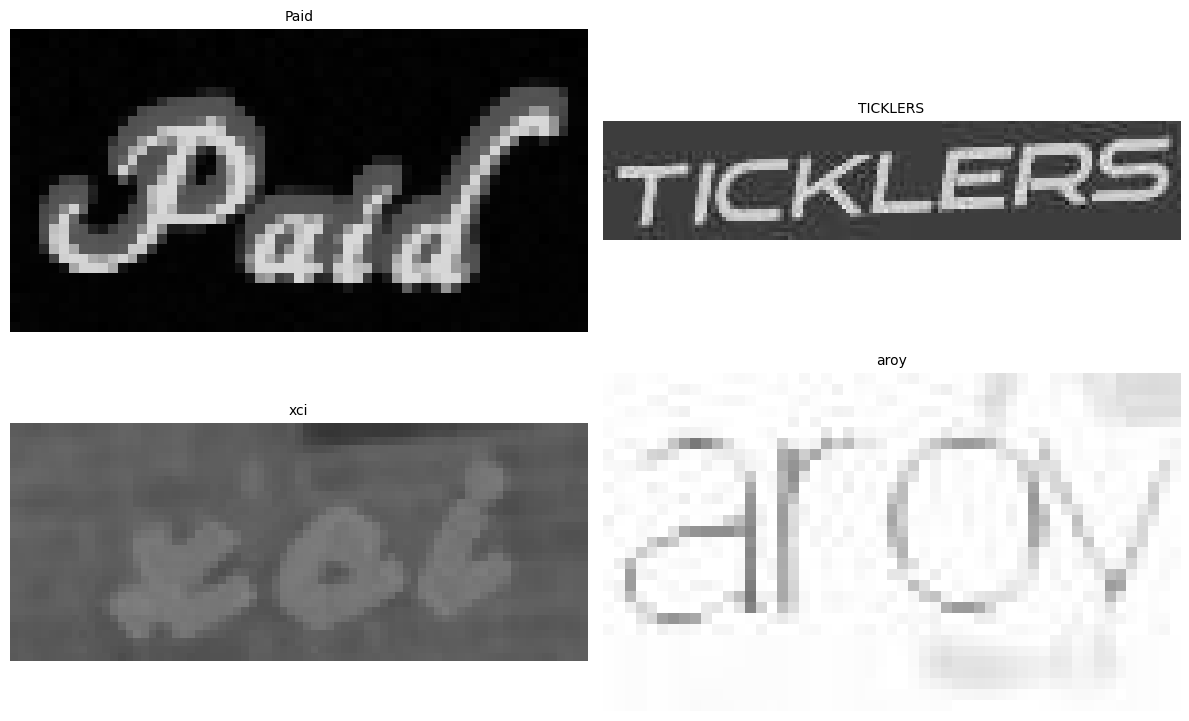

In [ ]:
# Lấy ngẫu nhiên 4 sample từ train_raw
indices = random.sample(range(len(train_raw)), 4)
samples = [train_raw[i] for i in indices]

# Vẽ 2×2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, sample in zip(axes, samples):
    img   = sample["image"]
    label = sample["label"]
    ax.imshow(img)
    ax.set_title(label, fontsize=10, wrap=True)
    ax.axis("off")

plt.tight_layout()
plt.show()

##Tiền xử lý text → token → id (dùng tập train để tạo vocab)

In [ ]:
#Loại bỏ các dấu phụ (accent marks) trên ký tự Unicode, ví dụ “é” → “e”, “ñ” → “n”.
def strip_accents(s):
    return "".join(c for c in unicodedata.normalize("NFKD", s)
                   if unicodedata.category(c) != "Mn")

In [ ]:
#Chuẩn hóa nhãn thô (ex["label"]) thành chuỗi thuần chữ–số–khoảng trắng, dễ tokenize.
def clean(t):
    if isinstance(t,list): t="".join(t)
    t=unicodedata.normalize("NFC",t.strip())
    t=t.replace("#"," "); t=strip_accents(t)
    return re.sub(r"[^\w\s]"," ",t)

In [ ]:
#Biến mỗi ký tự đã “clean” thành chỉ số nguyên tương ứng trong từ điển, thêm token bắt đầu/kết thúc câu, và pad cho đủ độ dài cố định MAX_LEN.
def toks2ids(toks):
    seq=[SOS_ID] + [word2idx.get(c,UNK_ID) for c in toks][:MAX_LEN-2]+[EOS_ID]
    seq+=[PAD_ID] * (MAX_LEN-len(seq)); return seq

In [ ]:
#Duyệt toàn bộ nhãn “đã clean”
#trong train_raw, thêm vào mỗi ký tự mới gặp. Kết quả là vocab bao gồm ký tự và token đặc biệt.
special = ["<PAD>","<UNK>"," ","<SOS>","<EOS>"]
word2idx = {tok:i for i,tok in enumerate(special)} # Ánh xạ token → chỉ số, bắt đầu với 5 token đặc biệt.
for ex in train_raw:
    for ch in clean(ex["label"]):
        if ch not in word2idx: word2idx[ch]=len(word2idx)
idx2word={i:t for t,i in word2idx.items()} #Đảo ngược mapping để chuyển ngược chỉ số → ký tự (dùng khi sinh text).

In [ ]:
PAD_ID, UNK_ID, SPACE_ID, SOS_ID, EOS_ID = (word2idx[t] for t in special)
VOCAB_SIZE = len(word2idx); MAX_LEN = CONFIG["MAX_LEN"]
print("Vocab =",VOCAB_SIZE)

Vocab = 67


In [ ]:
print(word2idx)

{'<PAD>': 0, '<UNK>': 1, ' ': 2, '<SOS>': 3, '<EOS>': 4, 'C': 5, 'O': 6, 'U': 7, 'N': 8, 'T': 9, 'E': 10, 'R': 11, 'P': 12, 'r': 13, 'i': 14, 'm': 15, 'a': 16, 'c': 17, 'y': 18, 'F': 19, 'u': 20, 't': 21, 'o': 22, 'l': 23, 'g': 24, 'W': 25, 'h': 26, 'e': 27, 'S': 28, 's': 29, 'p': 30, 'n': 31, 'd': 32, 'f': 33, 'M': 34, 'B': 35, 'A': 36, 'I': 37, 'J': 38, 'b': 39, 'H': 40, 'K': 41, 'z': 42, 'L': 43, 'v': 44, 'D': 45, 'j': 46, 'G': 47, 'V': 48, 'Z': 49, 'k': 50, 'Y': 51, 'w': 52, 'X': 53, 'Q': 54, 'x': 55, 'q': 56, '0': 57, '2': 58, '1': 59, '9': 60, '5': 61, '6': 62, '7': 63, '3': 64, '4': 65, '8': 66}


##Dataset & DataLoader

In [ ]:
#Tiền xử lý ảnh và augmentation
H,W=CONFIG["IMG_H"],CONFIG["IMG_W"]
train_tfm=transforms.Compose([
    transforms.Lambda(lambda im: im.resize((W,H))),
    transforms.RandomApply([
        transforms.RandomRotation(25,fill=0), #Xoay ngẫu nhiên ±25°; vùng trống được điền giá trị 0 (đen).
        transforms.RandomAffine(0,shear=15), #: Cắt xén (shear) ngẫu nhiên ±15° theo phương ngang hoặc dọc.
        transforms.RandomPerspective(0.6), #Biến dạng phối cảnh với mức độ 0.6, giả lập góc quay và độ sâu khác nhau.
        transforms.ColorJitter(0.4,0.4,0.4,0.1), #Thay đổi độ sáng, độ tương phản, độ bão hòa (±40%) và sắc độ (±10%).
        transforms.GaussianBlur(3,(0.1,0.2)) #Làm mờ Gaussian kernel 3×3, sigma ngẫu nhiên trong khoảng [0.1,0.2].
    ],p=0.8),
    transforms.ToTensor(), transforms.Normalize([0.5]*3,[0.5]*3) #Chuyển ảnh PIL (H×W×3, giá trị 0–255) thành tensor PyTorch (3×H×W), giá trị nổi (float) trong khoảng [0,1].
])
test_tfm = transforms.Compose([
    transforms.Lambda(lambda im: im.resize((W,H))),
    transforms.ToTensor(), transforms.Normalize([0.5]*3,[0.5]*3) #chuẩn hóa kênh màu RGB, Kết quả là tensor có giá trị cỡ khoảng [-1,1], giúp mô hình hội tụ ổn định hơn.
])

In [ ]:
#Tạo dataset từ HuggingFace (MJSynth)
#thành PyTorch Dataset, tự động áp augmentation/normalize và convert label → token IDs.
class MJDS(torch.utils.data.Dataset):
    def __init__(self, hf_ds, train=True):
        self.ds, self.train = hf_ds, train

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i):
        s = self.ds[i]
        # EasyOCR dataset đôi khi trả image dưới dạng list
        pil = s["image"][0] if isinstance(s["image"], list) else s["image"]
        # Chọn pipeline transform phù hợp (train/test)
        img = (train_tfm if self.train else test_tfm)(pil.convert("RGB"))
        # Chuyển label sạch thành chuỗi IDs
        ids = torch.tensor(toks2ids(clean(s["label"])), dtype=torch.long)
        return img, ids

In [ ]:
#Tạo Dataset và DataLoader cho cả train và validation.
def loaders(tr, va, bs=32):
    tr_ds, va_ds = MJDS(tr, True), MJDS(va, False)
    tr_dl = DataLoader(tr_ds, bs, True,  num_workers=2, pin_memory=True)
    va_dl = DataLoader(va_ds, bs, False, num_workers=2, pin_memory=True)
    return tr_ds, va_ds, tr_dl, va_dl

##ResNet‑50 encoder + Transformer decoder

In [ ]:
#Trích xuất đặc trưng từ ảnh.
class ResNetEncoder(nn.Module):
    def __init__(self, freeze=True): #ban đầu khóa weights của ResNet để chỉ train decoder, sau vài epoch mới unfreeze.
        super().__init__()
        res = models.resnet50(weights="IMAGENET1K_V1")
        if freeze:
            for p in res.parameters():
                p.requires_grad_(False)
        # Giữ lại phần convolutional backbone (loại bỏ fully-connected)
        self.backbone = nn.Sequential(
            res.conv1, res.bn1, res.relu, res.maxpool,
            res.layer1, res.layer2, res.layer3, res.layer4
        )

    def forward(self, x):
        # x: [B,3,H,W] → backbone → [B,2048,H',W']
        f = self.backbone(x).mean(2)      # trung bình qua chiều cao → [B,2048,W']
        return f.permute(0, 2, 1)         # → [B,W',2048]

In [ ]:
#Bổ sung thông tin vị trí cho chuỗi đầu vào của decoder.
class PosEnc(nn.Module):
    def __init__(self, d, drop=0.1, max_len=500):
        super().__init__()
        # Tạo ma trận positional encoding sinus/cosine
        pe = torch.zeros(max_len, d)
        pos = torch.arange(max_len).unsqueeze(1)            # [max_len,1]
        div = torch.exp(torch.arange(0,d,2) * -(math.log(10000.0)/d))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))         # [1,max_len,d]
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        # x: [B, T, d] → x + pe[:,:T,:] → dropout
        return self.drop(x + self.pe[:, :x.size(1), :])

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d, heads, ff, drop):
        super().__init__()
        #Capture phụ thuộc nội bộ trong target sequence.
        self.self_attn  = nn.MultiheadAttention(d, heads, drop, batch_first=True)
        #Kết nối giữa target và feature từ encoder.
        self.cross_attn = nn.MultiheadAttention(d, heads, drop, batch_first=True)
        #LayerNorm + residual + dropout: giúp ổn định và regularize.
        self.ff = nn.Sequential(
            nn.Linear(d, ff), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(ff, d)
        )
        self.norm1 = nn.LayerNorm(d)
        self.norm2 = nn.LayerNorm(d)
        self.norm3 = nn.LayerNorm(d)
        self.drop = nn.Dropout(drop)

    def forward(self, tgt, mem, mask, pad, ret=False):
        # 1) Self-attention trên target
        q, _ = self.self_attn(tgt, tgt, tgt,
                              attn_mask=mask,
                              key_padding_mask=pad,
                              need_weights=False)
        tgt = self.norm1(tgt + self.drop(q))
        # 2) Cross-attention: target query lên memory
        q, w = self.cross_attn(tgt, mem, mem,
                               average_attn_weights=False,
                               need_weights=ret)
        tgt = self.norm2(tgt + self.drop(q))
        # 3) Feed-forward
        tgt = self.norm3(tgt + self.drop(self.ff(tgt)))
        return (tgt, w) if ret else tgt

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        d, heads, layers, drop = 512, 8, 4, 0.1
        self.emb = nn.Embedding(VOCAB_SIZE, d, padding_idx=PAD_ID)
        self.pos = PosEnc(d, drop, MAX_LEN)
        self.layers = nn.ModuleList([
            DecoderLayer(d, heads, d*4, drop) for _ in range(layers)
        ])
        self.fc = nn.Linear(d, VOCAB_SIZE)

    def forward(self, tgt, mem, mask, pad, return_attn=False): #return_attn=True: trả thêm ma trận attention của từng layer (dùng để visualize)
        # 1) Embedding + positional
        x = self.emb(tgt) * math.sqrt(self.emb.embedding_dim)
        x = self.pos(x)
        attns = []
        # 2) Chạy qua các decoder layers
        for lyr in self.layers:
            if return_attn:
                x, w = lyr(x, mem, mask, pad, True)
                attns.append(w)
            else:
                x = lyr(x, mem, mask, pad, False)
        # 3) Dự đoán logits cho mỗi vị trí
        return (self.fc(x), attns) if return_attn else self.fc(x)

In [ ]:
#Kết hợp backbone CNN và Transformer decoder thành end-to-end.
class OCRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc  = ResNetEncoder(freeze=True)
        self.proj = nn.Linear(2048, 512)     # thu hẹp feature dim
        self.dec  = TransformerDecoder()

    def forward(self, img, tgt, mask, ret=False):
        # encoder → projection → decoder
        mem = self.proj(self.enc(img))       # [B, T_enc, 512]
        return self.dec(tgt, mem, mask, tgt.eq(PAD_ID), ret)

##helper (decoding, loss, mask)

In [ ]:
#Tạo ma trận upper-triangular có giá trị -inf ở phía trên để đảm bảo decoder tại vị trí i không “nhìn trước” quá i.
def causal_mask(L,dev):
    m=torch.triu(torch.ones(L,L,device=dev),1)
    return m.masked_fill(m==1,float("-inf"))

In [ ]:
#Cross-entropy loss với ignore_index=PAD_ID và label_smoothing=0.02.
def ce_loss(logits,tgt):
    return F.cross_entropy(logits.reshape(-1,VOCAB_SIZE),
                           tgt.reshape(-1),ignore_index=PAD_ID,
                           label_smoothing=0.02)

In [ ]:
#Sinh tuần tự (greedy decoding) token đầu ra:
#Bắt đầu với [SOS_ID].
#Mỗi bước, dùng logits dự đoán token tiếp theo (argmax).
#Nếu gặp EOS_ID, dừng.
@torch.no_grad()
def greedy_ids(model,img_tensor):
    mem=model.proj(model.enc(img_tensor.unsqueeze(0).to(device)))
    ys=torch.tensor([[SOS_ID]],device=device)
    for _ in range(MAX_LEN-1):
        logits=model.dec(ys,mem,causal_mask(ys.size(1),device),ys.eq(PAD_ID))
        nxt=logits[:,-1].argmax(-1,keepdim=True)
        ys=torch.cat([ys,nxt],1)
        if nxt.item()==EOS_ID: break
    return ys[0].tolist()

In [ ]:
#Chuyển chuỗi token IDs thành text, bỏ các token đặc biệt.
def ids2txt(ids):
    return "".join(idx2word[i] for i in ids
                   if i not in (PAD_ID,SOS_ID,EOS_ID,UNK_ID))

In [ ]:
# def tokens_from_ids(ids, drop_unk=True):
#     out=[]
#     for i in ids:
#         if i in (PAD_ID,SOS_ID,EOS_ID): continue
#         if i==UNK_ID and drop_unk: continue
#         out.append(idx2word.get(i,""))
#     return "".join(out)

##Train / validation

In [ ]:
#Nếu opt không None → training, ngược lại validation.
#Với training có thêm teacher-forcing với xác suất tf.
#Tính loss, backward (nếu training), clip grad, optimizer step, scheduler.
#Trả về (average_loss, accuracy).
def run_epoch(model,dl,opt=None,scaler=None,tf=1.0):
    train=opt is not None
    model.train() if train else model.eval()
    tot_l=tot_c=tot_n=0
    for img,tgt in dl:
        img,tgt=img.to(device),tgt.to(device)
        tgt_in=tgt[:,:-1].clone()
        if train and random.random()>tf:
            with torch.no_grad():
                sample=model(img,tgt_in,causal_mask(tgt_in.size(1),device))
                tgt_in[:,1::3]=sample.argmax(-1)[:,1::3]
        logits=model(img,tgt_in,causal_mask(tgt_in.size(1),device))
        loss=ce_loss(logits,tgt[:,1:])
        if train:
            scaler.scale(loss).backward(); scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(),1.)
            scaler.step(opt); scaler.update(); opt.zero_grad(True)
        tot_l+=loss.item()*img.size(0)
        pred=logits.argmax(-1); m=tgt[:,1:].ne(PAD_ID)
        tot_c+=(pred.eq(tgt[:,1:])&m).sum().item(); tot_n+=m.sum().item()
    return tot_l/len(dl.dataset), tot_c/tot_n

In [ ]:
#Tạo DataLoader, khởi tạo model, freeze encoder.
#Dùng AdamW + OneCycleLR(max_lr=LR_MAX).
#Huấn luyện tối đa EPOCHS, unfreeze encoder từ epoch 6.
#Early-stop sau 8 epoch không cải thiện validation loss.
#Lưu checkpoint tốt nhất.
def train_loop(tr_raw, va_raw):
    tr_ds, va_ds, tr_dl, va_dl = loaders(tr_raw, va_raw, CONFIG["BATCH"])
    model = OCRModel().to(device)

    #đóng băng encoder ban đầu
    for p in model.enc.parameters(): p.requires_grad_(False)

    opt   = torch.optim.AdamW(model.parameters(), lr=CONFIG["LR_MAX"], weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=CONFIG["LR_MAX"],
        steps_per_epoch=len(tr_dl), epochs=CONFIG["EPOCHS"], pct_start=0.25
    )
    scaler = GradScaler()

    best, patience = 1e9, 0
    tr_loss, va_loss, tr_acc, va_acc = [], [], [], []

    for e in range(1, CONFIG["EPOCHS"] + 1):
        #unfreeze encoder sau 5 epoch
        if e == 6:
            for p in model.enc.parameters(): p.requires_grad_(True)
            print(">>> unfreeze encoder")

        #train & valid
        l_tr, a_tr = run_epoch(model, tr_dl, opt, scaler,
                               tf=max(0.5, 0.9 - (e - 1) * 0.02))
        l_va, a_va = run_epoch(model, va_dl)

        sched.step()

        #log
        tr_loss.append(l_tr); va_loss.append(l_va)
        tr_acc .append(a_tr); va_acc .append(a_va)

        print(f"E{e:02d} | tr {l_tr:.2f}/{a_tr:.2f}  "
              f"val {l_va:.2f}/{a_va:.2f}")

        # ❺ lưu checkpoint tốt nhất
        if l_va < best:
            best, patience = l_va, 0
            torch.save(model.state_dict(), "best.pt")
        else:
            patience += 1
            if patience == 8:
                print("Early stop"); break

    return model, tr_ds, va_ds, tr_loss, va_loss, tr_acc, va_acc

##Wrapper: EasyOCR + Recognizer (chỉ dùng khi inference)

In [ ]:
#Kết hợp EasyOCR để phát hiện vùng text, rồi dùng model Transformer để “đọc” nội dung.
class OCRModelWithDetector(nn.Module):
    def __init__(self, recognizer: OCRModel, device, rectify=True):
        super().__init__()
        self.recognizer=recognizer.eval()
        self.reader=reader          # dùng reader đã khởi tạo
        self.rectify=rectify
        self.device=device

    # ----- forward = recognizer (cho train/val) -----
    def forward(self,img,tgt,mask,ret=False):
        return self.recognizer(img,tgt,mask,ret)

    # ----- infer = EasyOCR + recognizer -------------
    @torch.no_grad()
    def infer(self, pil_img: Image.Image):
        nd=preprocess_for_detect(pil_img)
        results=self.reader.readtext(nd,detail=1,paragraph=False,rotation_info=None)
        texts, polys = [], []
        for poly,_,_ in results:
            poly=np.array(poly)/2    # scale về gốc
            if self.rectify:
                crop=perspective_crop(pil_img,poly)
            else:
                xs,ys=poly[:,0],poly[:,1]
                crop=pil_img.crop((xs.min(),ys.min(),xs.max(),ys.max()))
            #Transform + predict bằng recognizer
            tensor=test_tfm(crop).to(self.device)
            txt=ids2txt(greedy_ids(self.recognizer,tensor))
            texts.append(txt); polys.append(poly.tolist())
        return texts,polys

In [ ]:
#Vẽ polygon và text lên ảnh gốc để hiển thị kết quả.
def draw_boxes(pil,texts,polys):
    img=cv2.cvtColor(np.array(pil),cv2.COLOR_RGB2BGR)
    for txt,poly in zip(texts,polys):
        p=np.array(poly,dtype=int)
        cv2.polylines(img,[p],True,(0,255,0),2)
        x,y=p[0]; cv2.putText(img,txt,(x,y-4),cv2.FONT_HERSHEY_SIMPLEX,
                              .7,(0,0,255),2,cv2.LINE_AA)
    return Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

##Kiến trúc mô hình

In [ ]:
# 1) Khởi tạo & in kiến trúc
model = OCRModel().to(device)
print(model)

# 2) Lấy một batch, forward thử
tr_ds, va_ds, tr_dl, va_dl = loaders(train_raw, val_raw, bs=8)
imgs, tgts = next(iter(tr_dl))

mask = causal_mask(tgts[:, :-1].size(1), device)

logits = model(imgs.to(device),               # ảnh
               tgts[:, :-1].to(device),       # đầu vào decoder (SOS + ...)
               mask)                          # causal mask

print("Logits shape:", logits.shape)          # B × T × VOCAB_SIZE


OCRModel(
  (enc): ResNetEncoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
      

##Huấn luyện & load best

In [ ]:
model, tr_ds, va_ds, tr_l, va_l, tr_a, va_a = train_loop(train_raw, val_raw)
model.load_state_dict(torch.load("best.pt",map_location=device))

E01 | tr 3.14/0.18  val 2.75/0.23
E02 | tr 2.77/0.23  val 2.64/0.25
E03 | tr 2.69/0.24  val 2.58/0.26
E04 | tr 2.65/0.25  val 2.55/0.27
E05 | tr 2.64/0.25  val 2.54/0.27
>>> unfreeze encoder
E06 | tr 2.61/0.26  val 2.46/0.29
E07 | tr 2.56/0.27  val 2.42/0.30
E08 | tr 2.52/0.28  val 2.38/0.32
E09 | tr 2.48/0.29  val 2.25/0.36
E10 | tr 2.43/0.31  val 2.16/0.39
E11 | tr 2.35/0.33  val 2.00/0.43
E12 | tr 2.28/0.36  val 1.86/0.47
E13 | tr 2.18/0.38  val 1.77/0.51
E14 | tr 2.12/0.40  val 1.67/0.54
E15 | tr 2.02/0.43  val 1.54/0.58
E16 | tr 1.98/0.44  val 1.48/0.59
E17 | tr 1.91/0.46  val 1.39/0.63
E18 | tr 1.86/0.48  val 1.31/0.65
E19 | tr 1.86/0.48  val 1.26/0.66
E20 | tr 1.79/0.50  val 1.20/0.69
E21 | tr 1.77/0.50  val 1.17/0.70
E22 | tr 1.71/0.52  val 1.23/0.67
E23 | tr 1.70/0.53  val 1.10/0.72
E24 | tr 1.68/0.53  val 1.10/0.72
E25 | tr 1.63/0.54  val 1.03/0.74
E26 | tr 1.59/0.56  val 1.10/0.72
E27 | tr 1.58/0.56  val 1.03/0.74
E28 | tr 1.53/0.58  val 0.95/0.77
E29 | tr 1.51/0.58  val 0.9

<All keys matched successfully>

In [ ]:
# wrapper=OCRModelWithDetector(model,device,rectify=True)   # dùng cho inference

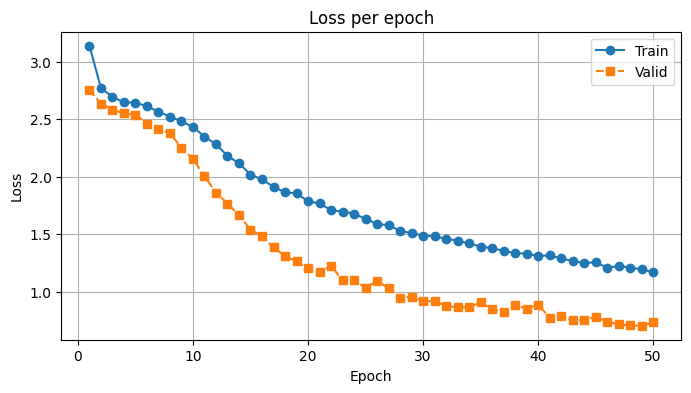

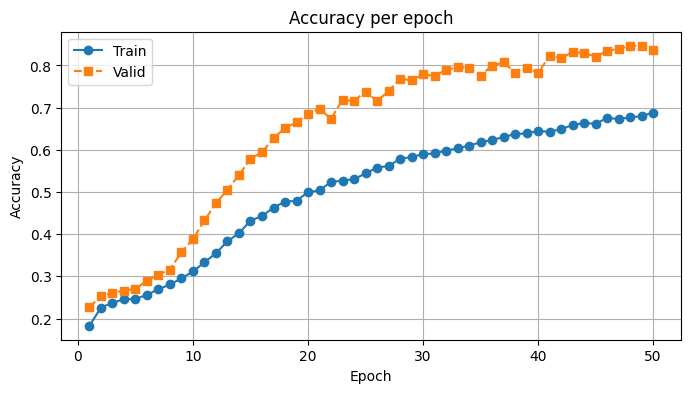

In [ ]:
epochs = range(1, len(tr_l) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, tr_l, '-o', label='Train')
plt.plot(epochs, va_l, '--s', label='Valid')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss per epoch'); plt.grid(); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, tr_a, '-o', label='Train')
plt.plot(epochs, va_a, '--s', label='Valid')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy per epoch'); plt.grid(); plt.legend(); plt.show()

##Demo một vài ảnh ở tập validation

In [ ]:
#Tương tự greedy_ids nhưng trả kèm attention maps từ layer cuối cùng cho mỗi bước decode.
@torch.no_grad()
def greedy_ids_attn(model,img):
    mem=model.proj(model.enc(img.unsqueeze(0).to(device)))
    ys=torch.tensor([[SOS_ID]],device=device); maps=[]
    for _ in range(MAX_LEN-1):
        mask=gen_sub_mask(ys.size(1),device)
        logits,attn=model.dec(ys,mem,mask,ys.eq(PAD_ID),True)
        maps.append(attn[-1].mean(1)[0,-1])
        nxt=logits[:,-1].argmax(-1,keepdim=True); ys=torch.cat([ys,nxt],1)
        if nxt.item()==EOS_ID: break
    return ys, torch.stack(maps)

In [ ]:
#Tạo causal mask cho chiều dài L.
def gen_sub_mask(L,dev):
    m=torch.triu(torch.ones(L,L,device=dev),1)
    return m.masked_fill(m==1,float("-inf"))

In [ ]:
@torch.no_grad()
def viz_val_full(model, ds, n=6, mode="mean", cmap="magma"):
    """
    mode = "mean" | "sum" | "both"
    - Sinh text + attention maps với mỗi
    - Chuyển vector attention → heatmap cùng kích thước với chiều rộng feature.
    - "mean":   trung bình attention của tất cả bước decode
    - "sum":    cộng dồn attention của tất cả bước decode
    - "both":   hiển thị cả hai (ảnh gốc + heat-map mean | heat-map sum)
    """
    show_both = (mode == "both")
    ncols = 3 if show_both else 2
    fig, axs = plt.subplots(n, ncols, figsize=(4.5*ncols, 3*n))

    if n == 1: axs = [axs]                # đảm bảo iterable

    for row in axs:
        # 1) lấy random sample
        img, tgt = ds[random.randint(0, len(ds)-1)]
        txt_gt   = ids2txt(tgt.tolist())
        ids, maps = greedy_ids_attn(model, img)        # maps: [T-1, src_len]
        txt_pr   = ids2txt(ids.squeeze().tolist())

        H, W = img.size(1), img.size(2)

        # Helper: convert vec[src_len] -> heat[H,W]
        def vec2heat(vec):
            up = F.interpolate(vec.unsqueeze(0).unsqueeze(0), size=W,
                               mode="linear", align_corners=False)[0, 0]
            return up.unsqueeze(0).repeat(H, 1)

        heat_mean = vec2heat(maps.mean(0))
        heat_sum  = vec2heat(maps.sum(0))

        # ----- cột 0: ảnh gốc + GT/PR -----
        ax0 = row[0]
        ax0.imshow((img*0.5 + 0.5).permute(1,2,0).cpu())
        ax0.axis("off")
        ax0.set_title(f"GT: {txt_gt}\nPR: {txt_pr}", fontsize=9)

        # ----- cột 1: heat-map mean (hoặc sum nếu ncols==2 & mode=="sum") -----
        ax1 = row[1]
        ax1.imshow((img*0.5 + 0.5).permute(1,2,0).cpu())
        ax1.imshow(heat_mean.cpu() if not show_both and mode=="mean" else
                   heat_sum.cpu()  if not show_both else
                   heat_mean.cpu(), alpha=0.45, cmap=cmap)
        ax1.axis("off")
        ax1.set_title("Attention (mean)" if (show_both or mode=="mean")
                      else "Attention (sum)", fontsize=9)

        # ----- cột 2 (nếu show_both): heat-map sum -----
        if show_both:
            ax2 = row[2]
            ax2.imshow((img*0.5 + 0.5).permute(1,2,0).cpu())
            ax2.imshow(heat_sum.cpu(), alpha=0.45, cmap=cmap)
            ax2.axis("off")
            ax2.set_title("Attention (sum)", fontsize=9)

    plt.tight_layout(); plt.show()

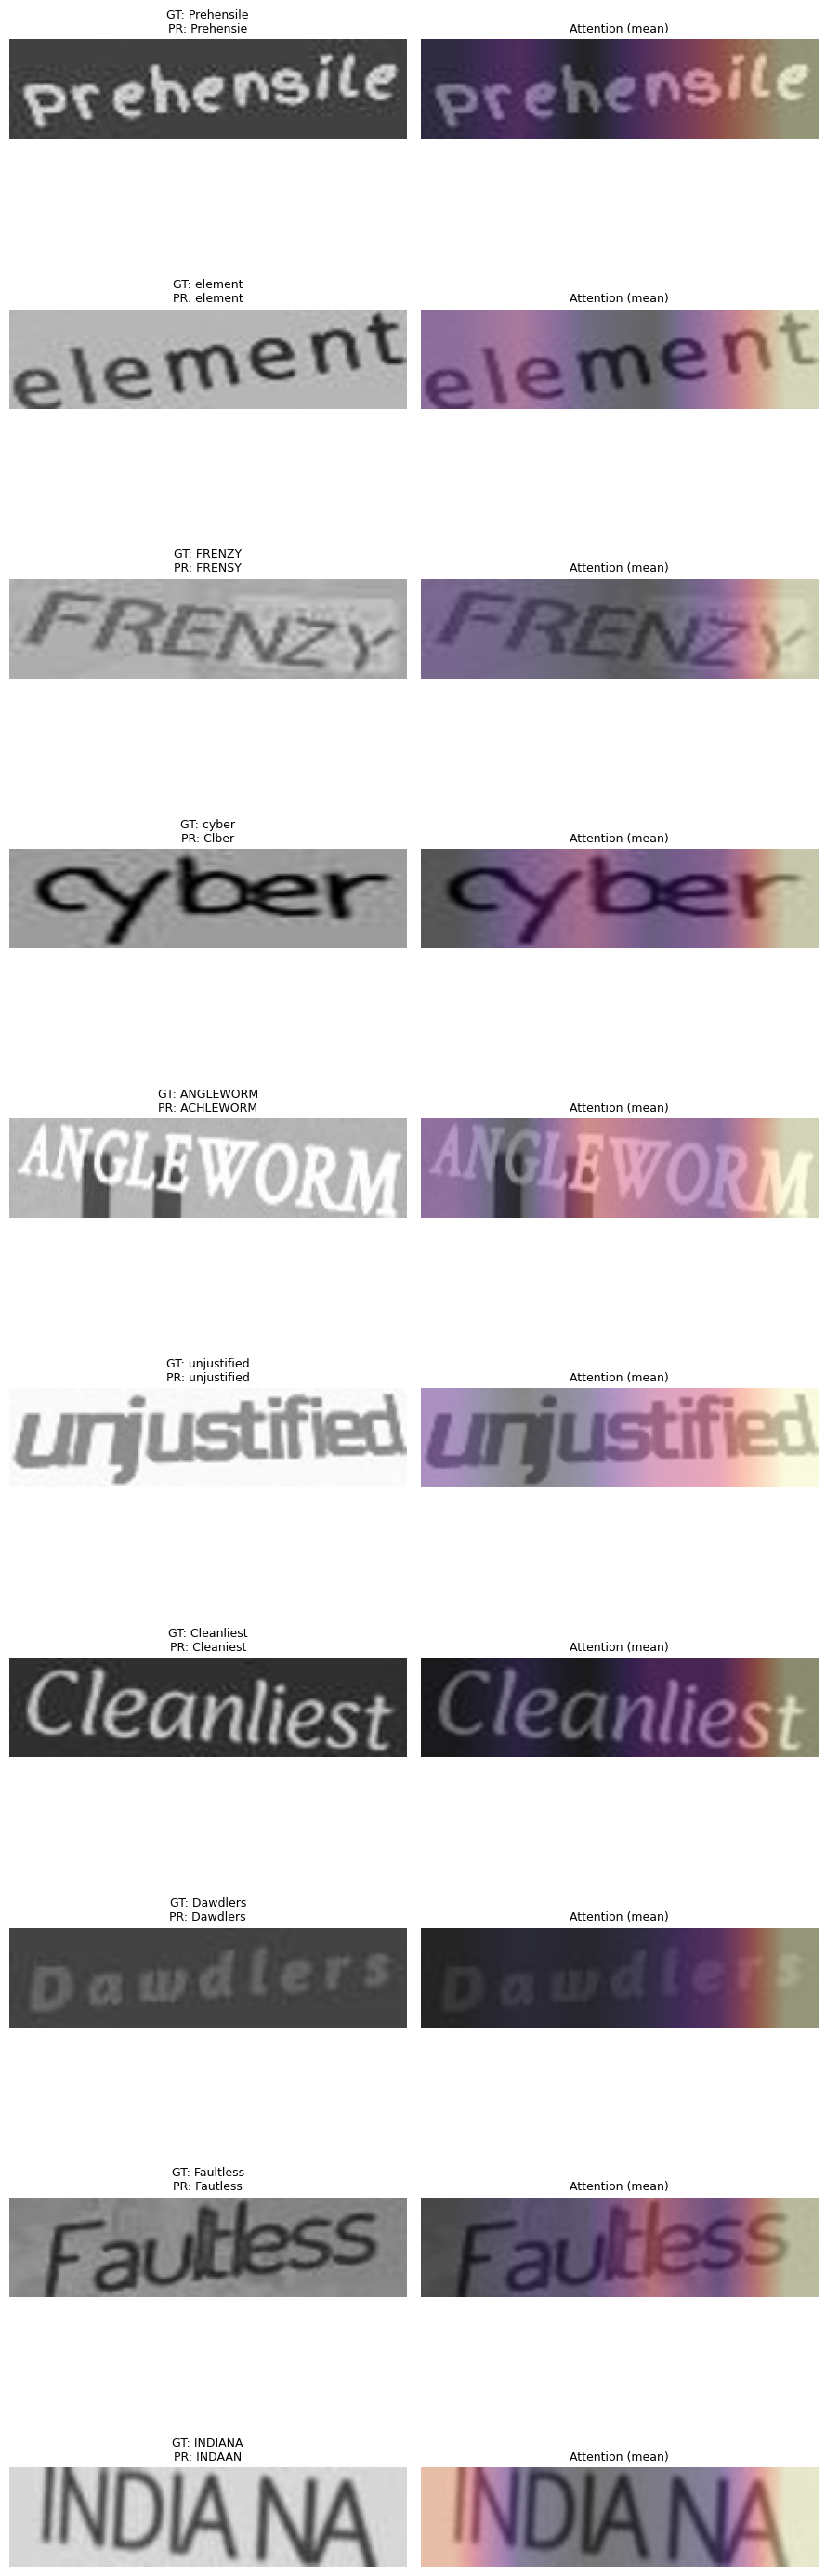

In [ ]:
viz_val_full(model, va_ds, n=10, mode="mean")

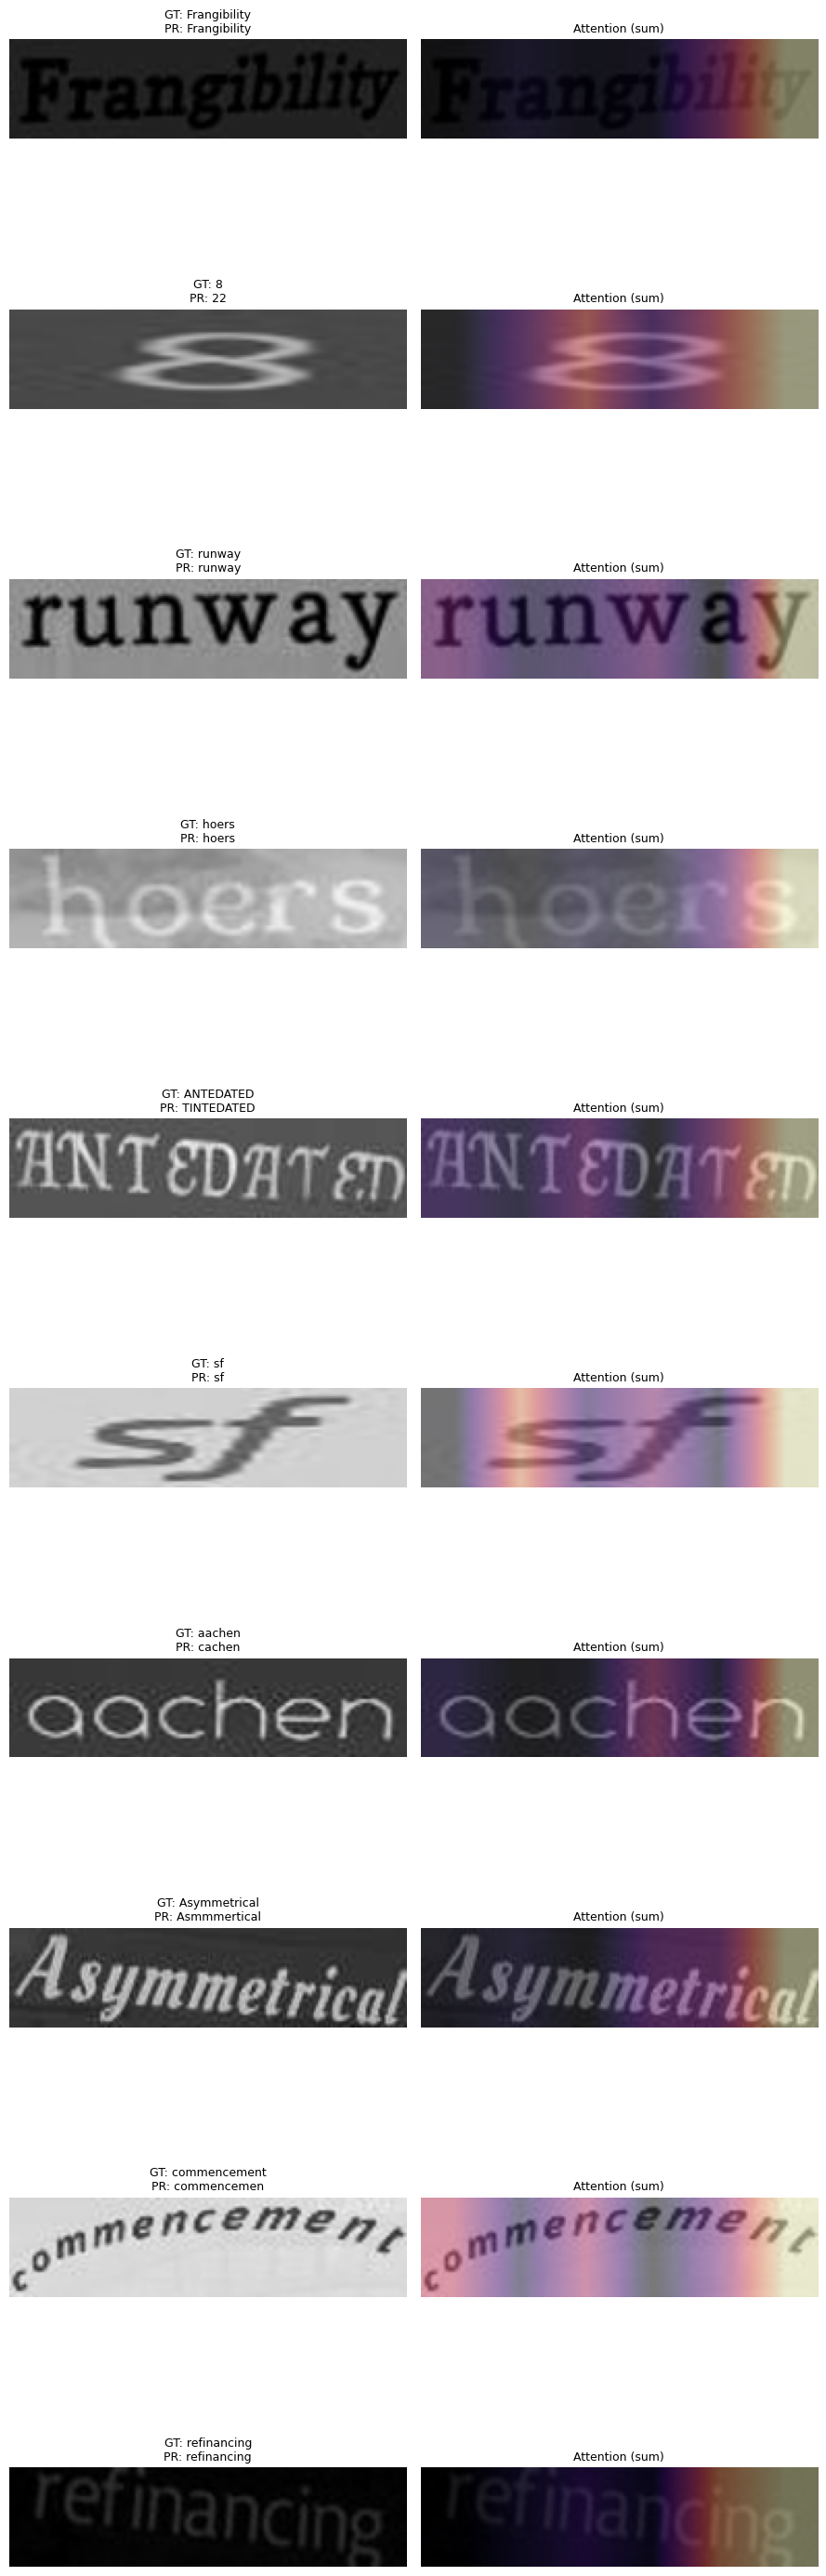

In [ ]:
viz_val_full(model, va_ds, n=10, mode="sum")

##Demo inference một vài ảnh khác

Predicted: ['5', 'Speedway', 'loooe', 'ONE', 'WAY']


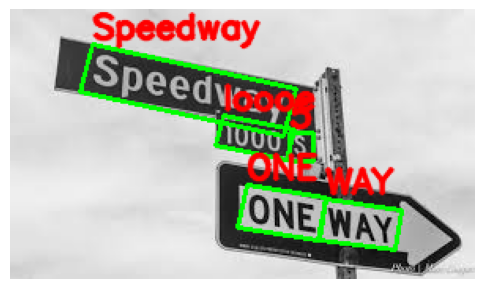

In [ ]:
pil=Image.open("/content/images.jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

Predicted: ['PANDORA']


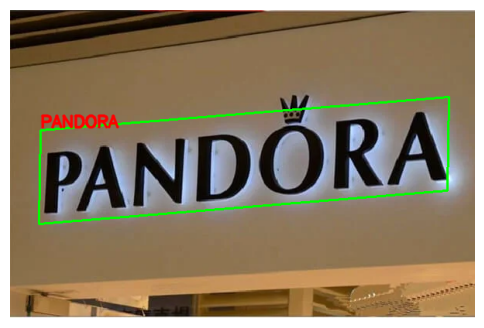

In [ ]:
pil=Image.open("/content/test2.jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

Predicted: ['TOYOTA']


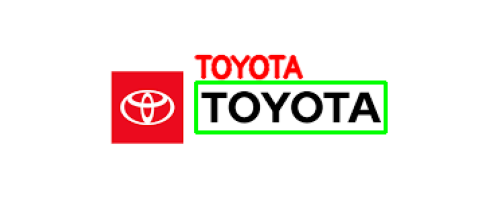

In [ ]:
pil=Image.open("/content/test3.jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

Predicted: ['ftefor', 'fly']


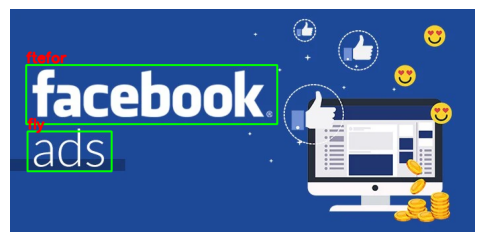

In [ ]:
pil=Image.open("/content/test4.jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

Predicted: ['CLLSTOMM', 'Antrons', 'Stardder']


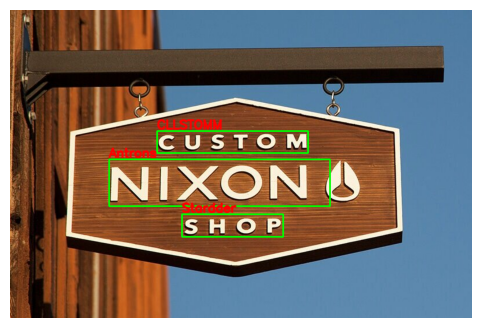

In [ ]:
pil=Image.open("/content/test8.jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

Predicted: ['seated']


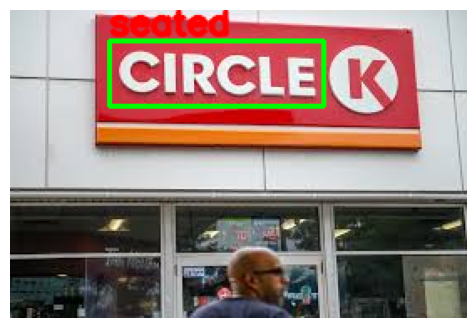

In [ ]:
pil=Image.open("/content/test9.jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

Predicted: ['STARBUCKS', 'COFFE']


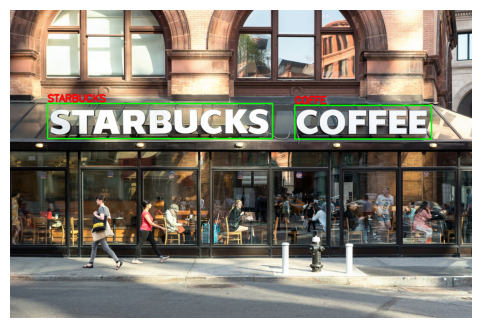

In [ ]:
pil=Image.open("/content/test10.jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

Predicted: ['SRICTTY', 'Conspassaaabing', 'KOREAN', 'cusine', 'cor', 'stacke']


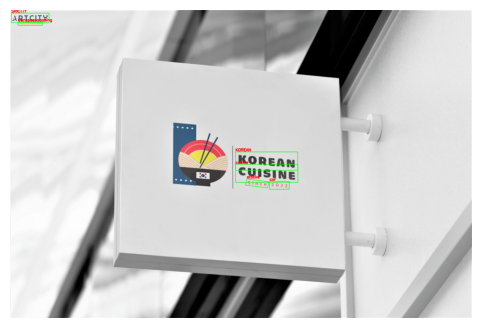

In [ ]:
pil=Image.open("/content/test11.jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

Predicted: ['SISTEESTER', 'Shard', 'UNTED']


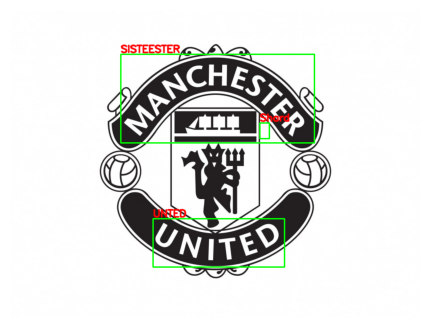

In [ ]:
pil=Image.open("/content/862_manchester_united_fc.jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

Predicted: ['TILE', 'CORIEER', 'SHOP']


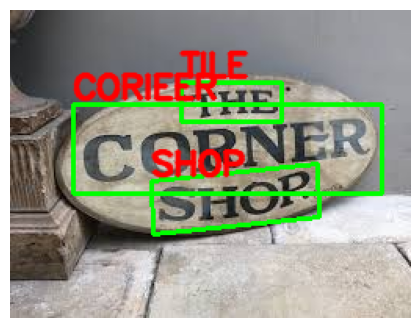

In [ ]:
pil=Image.open("/content/images (1).jpg").convert("RGB")  # thay bằng ảnh của bạn
texts,boxes=wrapper.infer(pil)
print("Predicted:",texts)
plt.figure(figsize=(6,4)); plt.imshow(draw_boxes(pil,texts,boxes)); plt.axis("off")
plt.show()

##Code dùng cho sau khi tải best.pt lên gg colab

In [ ]:
#rebuild vocab constants
mapping = {
    '<PAD>': 0, '<UNK>': 1, ' ': 2, '<SOS>': 3, '<EOS>': 4,
    'C': 5, 'O': 6, 'U': 7, 'N': 8, 'T': 9, 'E': 10, 'R': 11,
    'P': 12, 'r': 13, 'i': 14, 'm': 15, 'a': 16, 'c': 17, 'y': 18,
    'F': 19, 'u': 20, 't': 21, 'o': 22, 'l': 23, 'g': 24, 'W': 25,
    'h': 26, 'e': 27, 'S': 28, 's': 29, 'p': 30, 'n': 31, 'd': 32,
    'f': 33, 'M': 34, 'B': 35, 'A': 36, 'I': 37, 'J': 38, 'b': 39,
    'H': 40, 'K': 41, 'z': 42, 'L': 43, 'v': 44, 'D': 45, 'j': 46,
    'G': 47, 'V': 48, 'Z': 49, 'k': 50, 'Y': 51, 'w': 52, 'X': 53,
    'Q': 54, 'x': 55, 'q': 56,
    '0': 57, '2': 58, '1': 59, '9': 60, '5': 61, '6': 62, '7': 63,
    '3': 64, '4': 65, '8': 66
}

# Dùng luôn mapping đó làm word2idx
word2idx = mapping
idx2word = {i:tok for tok,i in mapping.items()}

PAD_ID = word2idx["<PAD>"]
UNK_ID = word2idx["<UNK>"]
SOS_ID = word2idx["<SOS>"]
EOS_ID = word2idx["<EOS>"]

VOCAB_SIZE = len(word2idx)
MAX_LEN    = 120

In [ ]:
print(VOCAB_SIZE)

67


In [ ]:
model = OCRModel().to(device)         # phải khớp kiến trúc đã train
ckpt_path = "/content/best.pt"        # mặc định upload ở /content
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()                          # chuyển sang eval mode

OCRModel(
  (enc): ResNetEncoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
      

In [ ]:
wrapper = OCRModelWithDetector(model, device, rectify=True) #chạy khi tải best.pt

Predicted: ['IN', 'MAREHHHEWAN', 'LAVEVOU', 'FALL', 'LOVE', 'WITH', 'YOUR', 'PROBLEMS', 'Tooo']


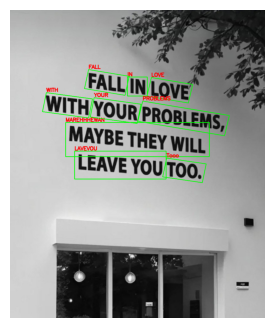

In [ ]:
from PIL import Image
pil = Image.open("/content/facebook.jpg").convert("RGB")  # thay path

texts, polys = wrapper.infer(pil)    # EasyOCR detect ➜ recognizer decode
print("Predicted:", texts)

# vẽ kết quả
result = draw_boxes(pil, texts, polys)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4)); plt.imshow(result); plt.axis("off"); plt.show()